# NYC Yellow Taxi Trip Data: Pickup Prediction
- this notebook covers my code for the NYC Yellow Taxi Trip Data dataset, in which I have trained some models to predict the pickup density. The dataset can be found [here](https://www.kaggle.com/elemento/nyc-yellow-taxi-trip-data).
- This work is largely inspired by the Applied AI Course, and I would like to say a special thanks to the entire team of Applied AI.

# Installing & Importing Packages

In [2]:
#!pip install graphviz
#!pip install dask
#!pip install "dask[complete]" 
#!pip install toolz
#!pip install cloudpickle
#!pip install folium
#!pip install gpxpy
#!pip install pyroomacoustics
#!pip install xgboost
#!pip install prettytable
#!pip install dash plotly pandas

In [3]:
import os
import time
import math
import scipy
import pickle
import warnings
import datetime
import numpy as np
import pandas as pd
import matplotlib
import seaborn as sns
import xgboost as xgb
import matplotlib.pylab as plt
from graphviz import Digraph
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.stattools import adfuller

# This library helps to open street map
import folium 

# Similar to pandas, but helps in parallel computing
import dask.dataframe as dd

# This library is used while we calculate the straight line distance between two (lat, lon) pairs 
# in miles. Get the haversine distance
import gpxpy.geo 

# Used to determine the size of plots
from matplotlib import rcParams 

# Used for detection of peaks
from pyroomacoustics.doa.detect_peaks import detect_peaks


from sklearn.cluster import MiniBatchKMeans, KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LinearRegression

from prettytable import PrettyTable
from datetime import datetime as dt

matplotlib.use('nbagg');
warnings.filterwarnings("ignore");
%matplotlib inline

In [4]:
# To find the running time of the entire kernel
globalstart = dt.now()

## Data Information
- The data used in the attached datasets were collected and provided to the NYC Taxi and Limousine Commission (TLC). 

## Information on Taxis
#### Yellow Taxi: Yellow Medallion Taxicabs
These are the famous NYC yellow taxis that provide transportation exclusively through street-hails. The number of taxicabs is limited by a finite number of medallions issued by the TLC. You access this mode of transportation by standing in the street and hailing an available taxi with your hand. The pickups are not pre-arranged.

Credits: Quora

#### Footnote:
In the given notebook we are considering only the yellow taxis data for the months of Jan 2015 & Jan - Mar 2016

## Data Collection
- In this dataset, we have collected the data for 4 months particularly:
- Based upon the models, either we will be using the 2015 data as the training dataset and the 2016 data as the test set, or, we will be using the 2016 data solely.

# ML Problem Formulation
### Time-series Forecasting and Regression
- To find number of pickups, given location cordinates (latitude and longitude) and time, in the query region and surrounding regions.
-  To solve the above problem, we would be using data collected in Jan 2015 to predict the pickups in Jan-Mar 2016.

# Performance metrics
1. Mean Absolute percentage error (MAPE)
2. Mean Squared error (MSE)

### MAPE
- we are using an alternate version of MAPE, which accounts for the cases, when the absolute value *(i.e., the denominator value)* is 0.
- In the alternate version, instead of using the absolute value in the denominator, we use the average of the absolute values in the denominator, and since, this is a constant, hence, we can take this quantity out from the summation.

# 1. Data Cleaning
- In this section we will be doing univariate analysis and removing outlier/illegitimate values which may be caused due to some error.
- We will do the entire univariate analysis on Jan 2015 data, and whatever pre-processing we do based on the insights, will be applied to the data from all the 4 months.

In [5]:
# The table below shows few datapoints along with all our features
month = dd.read_csv('yellow_tripdata_2015-01.csv')
print(month.columns)

month.head()

Index(['VendorID', 'tpep_pickup_datetime', 'tpep_dropoff_datetime',
       'passenger_count', 'trip_distance', 'pickup_longitude',
       'pickup_latitude', 'RateCodeID', 'store_and_fwd_flag',
       'dropoff_longitude', 'dropoff_latitude', 'payment_type', 'fare_amount',
       'extra', 'mta_tax', 'tip_amount', 'tolls_amount',
       'improvement_surcharge', 'total_amount'],
      dtype='object')


VendorID tpep_pickup_datetime tpep_dropoff_datetime  passenger_count  \
0         2  2015-01-15 19:05:39   2015-01-15 19:23:42                1   
1         1  2015-01-10 20:33:38   2015-01-10 20:53:28                1   
2         1  2015-01-10 20:33:38   2015-01-10 20:43:41                1   
3         1  2015-01-10 20:33:39   2015-01-10 20:35:31                1   
4         1  2015-01-10 20:33:39   2015-01-10 20:52:58                1   

   trip_distance  pickup_longitude  pickup_latitude  RateCodeID  \
0           1.59        -73.993896        40.750111           1   
1           3.30        -74.001648        40.724243           1   
2           1.80        -73.963341        40.802788           1   
3           0.50        -74.009087        40.713818           1   
4           3.00        -73.971176        40.762428           1   

  store_and_fwd_flag  dropoff_longitude  dropoff_latitude  payment_type  \
0                  N         -73.974785         40.750618             1   
1                  N         -73.994415         40.759109             1   
2                  N         -73.951820         40.824413             2   
3                  N         -74.004326         40.719986             2   
4                  N         -74.004181         40.742653             2   

   fare_amount  extra  mta_tax  tip_amount  tolls_amount  \
0         12.0    1.0      0.5        3.25           0.0   
1         14.5    0.5      0.5        2.00           0.0   
2          9.5    0.5      0.5        0.00           0.0   
3          3.5    0.5      0.5        0.00           0.0   
4         15.0    0.5      0.5        0.00           0.0   

   improvement_surcharge  total_amount  
0                    0.3         17.05  
1                    0.3         17.80  
2                    0.3         10.80  
3                    0.3          4.80  
4                    0.3         16.30

## 1.1. Pickup Latitude and Pickup Longitude
- It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates (lat,long) - (40.5774, -74.15) & (40.9176,-73.7004)
- Hence, any cordinates not within this cordinate range, are not considered by us, as we are only concerned with pickups which originate within New York.

In [6]:
import folium

# Filter out the locations that are outside the bounding box of NYC
outlier_locations = month[((month.pickup_longitude < -74.15) | (month.pickup_longitude > -73.7004)) | \
                         ((month.pickup_latitude < 40.5774) | (month.pickup_latitude > 40.9176))]

print("Number of Outlier Locations:", len(outlier_locations))

# Create a base map centered around NYC
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='OpenStreetMap')

# Plot only the first 1000 outliers to keep it manageable
sample_locations = outlier_locations.head(1000)

for i, j in sample_locations.iterrows():
    # Ensure coordinates are valid
    if (j['pickup_latitude'] != 0 and j['pickup_longitude'] != 0):
        folium.Marker(
            location=[j['pickup_latitude'], j['pickup_longitude']]
        ).add_to(map_osm)

# Display the map
map_osm

Number of Outlier Locations: 247742


#### Observations:
- As you can see above that there are some points just outside the boundary but there are a few that are in either South america, Mexico or Canada.

## 1.2. Dropoff Latitude & Dropoff Longitude
- It is inferred from the source https://www.flickr.com/places/info/2459115 that New York is bounded by the location cordinates (lat,long) - (40.5774, -74.15) & (40.9176,-73.7004)
- Hence, any cordinates not within this cordinate range, are not considered by us, as we are only concerned with dropoffs which are within New York.

In [7]:
import folium
import pandas as pd  # Ensure pandas is imported for DataFrame operations

# Filter locations that are outside the bounding box of NYC
outlier_locations = month[((month.dropoff_longitude < -74.15) | (month.dropoff_longitude > -73.7004)) | \
                         ((month.dropoff_latitude < 40.5774) | (month.dropoff_latitude > 40.9176))]

print("Number of Outlier Locations:", len(outlier_locations))

# Create a base map centered around NYC
map_osm = folium.Map(location=[40.734695, -73.990372], tiles='OpenStreetMap')

# Plot only the first 1000 outliers to keep it manageable
sample_locations = outlier_locations.head(1000)

for i, j in sample_locations.iterrows():
    # Ensure coordinates are valid and in correct format
    if pd.notna(j['dropoff_latitude']) and pd.notna(j['dropoff_longitude']):
        folium.Marker(
            location=[j['dropoff_latitude'], j['dropoff_longitude']]
        ).add_to(map_osm)

# Display the map in a Jupyter Notebook or similar environment
map_osm


Number of Outlier Locations: 264440


#### Observations:
- The observations here are similar to those obtained while analysing pickup latitude and longitude

## 1.3. Trip Durations:
- According to NYC Taxi & Limousine Commision Regulations, the maximum allowed trip duration in a 24 hour interval is 12 hours.

In [8]:
# The timestamps are converted to unix so as to get duration (trip-time) & speed.
# Also, the pickup-times in unix are used while binning 

# In the data, we have time in the format "YYYY-MM-DD HH:MM:SS" 
# We convert this string to python time format and then into unix time stamp
# https://stackoverflow.com/a/27914405
def convert_to_unix(s):
    return time.mktime(datetime.datetime.strptime(s, "%Y-%m-%d %H:%M:%S").timetuple())

# We return a data-frame which contains the columns
# 1.'passenger_count'   : Self-explanatory
# 2.'trip_distance'     : Self-explanatory
# 3.'pickup_longitude'  : Self-explanatory
# 4.'pickup_latitude'   : Self-explanatory
# 5.'dropoff_longitude' : Self-explanatory
# 6.'dropoff_latitude'  : Self-explanatory
# 7.'total_amount'      : Total fare that was paid
# 8.'trip_times'        : Duration of each trip
# 9.'pickup_times       : Pickup time converted into unix time 
# 10.'Speed'            : Velocity of each trip

def return_with_trip_times(month):
    duration = month[['tpep_pickup_datetime','tpep_dropoff_datetime']].compute()
    
    # Pickups and dropoffs to unix time
    duration_pickup = [convert_to_unix(x) for x in duration['tpep_pickup_datetime'].values]
    duration_drop = [convert_to_unix(x) for x in duration['tpep_dropoff_datetime'].values]
    
    # Calculate the duration of trips
    # Division by 60 converts the difference from seconds to minutes
    durations = (np.array(duration_drop) - np.array(duration_pickup))/float(60)

    # Append durations of trips and speed in miles/hr to a new dataframe
    new_frame = month[['passenger_count','trip_distance','pickup_longitude','pickup_latitude',
        'dropoff_longitude','dropoff_latitude','total_amount']].compute()
    
    new_frame['trip_times'] = durations
    new_frame['pickup_times'] = duration_pickup
    new_frame['Speed'] = 60*(new_frame['trip_distance']/new_frame['trip_times'])
    
    return new_frame

frame_with_durations = return_with_trip_times(month)
frame_with_durations.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  
0  1.421329e+09   5.285319  
1  1.420902e+09   9.983193  
2  1.420902e+09  10.746269  
3  1.420902e+09  16.071429  
4  1.420902e+09   9.318378

<Axes: ylabel='trip_times'>

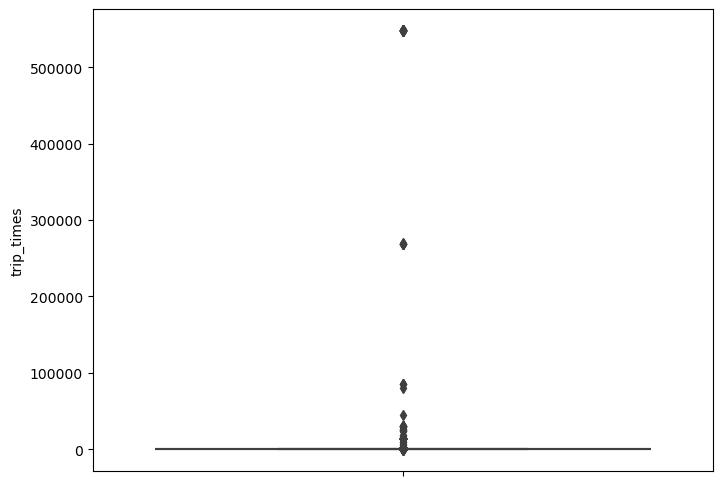

In [9]:
# The skewed box-plot shows us the presence of outliers 
plt.figure(figsize = (8, 6))
sns.boxplot(y="trip_times", data = frame_with_durations)

In [10]:
# Calculating 0-100th percentile to find the correct percentile value for removal of outliers
var = frame_with_durations["trip_times"].values
var = np.sort(var, axis = None)

for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is", var[-1])

0 percentile value is -1211.0166666666667
10 percentile value is 3.8333333333333335
20 percentile value is 5.383333333333334
30 percentile value is 6.816666666666666
40 percentile value is 8.3
50 percentile value is 9.95
60 percentile value is 11.866666666666667
70 percentile value is 14.283333333333333
80 percentile value is 17.633333333333333
90 percentile value is 23.45
100 percentile value is 548555.6333333333


In [11]:
# Looking further from the 99th percentile
var = frame_with_durations["trip_times"].values
var = np.sort(var,axis = None)

for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print ("100 percentile value is", var[-1])

90 percentile value is 23.45
91 percentile value is 24.35
92 percentile value is 25.383333333333333
93 percentile value is 26.55
94 percentile value is 27.933333333333334
95 percentile value is 29.583333333333332
96 percentile value is 31.683333333333334
97 percentile value is 34.46666666666667
98 percentile value is 38.71666666666667
99 percentile value is 46.75
100 percentile value is 548555.6333333333


In [12]:
# Removing data based on our analysis and TLC regulations
frame_with_durations_modified = frame_with_durations[(frame_with_durations.trip_times > 1) & \
    (frame_with_durations.trip_times < 720)]

In [13]:
frame_with_durations_modified.head()

passenger_count  trip_distance  pickup_longitude  pickup_latitude  \
0                1           1.59        -73.993896        40.750111   
1                1           3.30        -74.001648        40.724243   
2                1           1.80        -73.963341        40.802788   
3                1           0.50        -74.009087        40.713818   
4                1           3.00        -73.971176        40.762428   

   dropoff_longitude  dropoff_latitude  total_amount  trip_times  \
0         -73.974785         40.750618         17.05   18.050000   
1         -73.994415         40.759109         17.80   19.833333   
2         -73.951820         40.824413         10.80   10.050000   
3         -74.004326         40.719986          4.80    1.866667   
4         -74.004181         40.742653         16.30   19.316667   

   pickup_times      Speed  
0  1.421329e+09   5.285319  
1  1.420902e+09   9.983193  
2  1.420902e+09  10.746269  
3  1.420902e+09  16.071429  
4  1.420902e+09   9.318378

<Axes: ylabel='trip_times'>

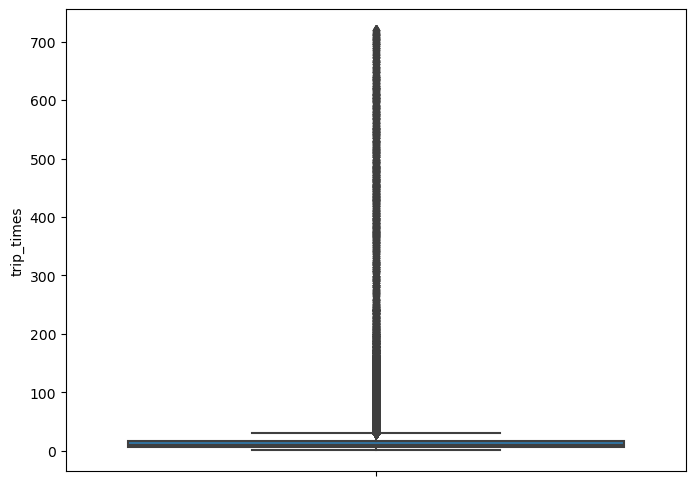

In [14]:
# Box-plot after removal of outliers
plt.figure(figsize = (8, 6))
sns.boxplot(y="trip_times", data = frame_with_durations_modified)

<Axes: xlabel='trip_times', ylabel='Density'>

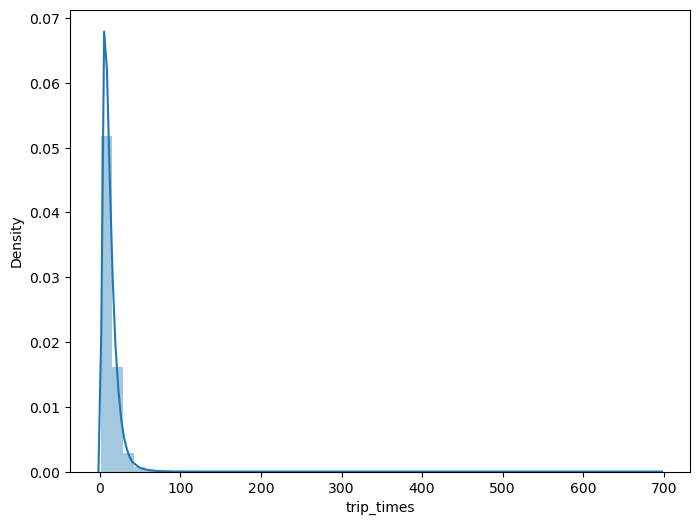

In [15]:
# PDF of trip-times after removing the outliers
tt_sample = frame_with_durations_modified['trip_times'].sample(n = 200000)

plt.figure(figsize = (8, 6))
sns.distplot(tt_sample, hist=True, kde=True)

In [16]:
# Converting the values to log-values to check for log-normal distribution
frame_with_durations_modified['log_times'] = [math.log(i) for i in frame_with_durations_modified['trip_times'].values]

<Axes: xlabel='log_times', ylabel='Density'>

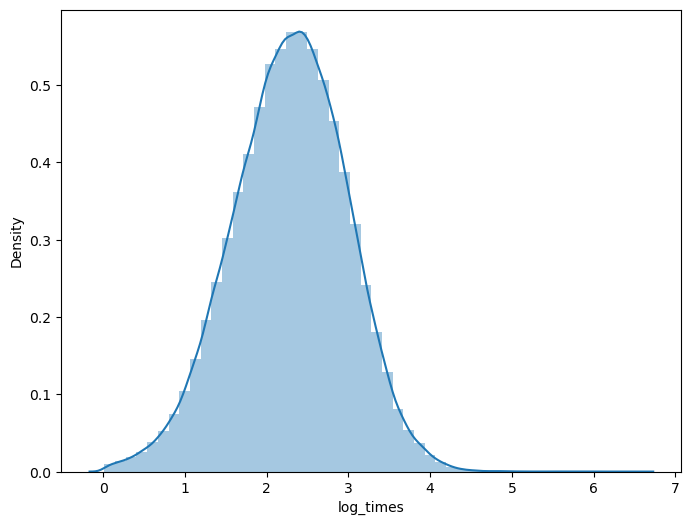

In [17]:
# PDF of log-values of trip-times
ltt_sample = frame_with_durations_modified['log_times'].sample(n = 200000)

plt.figure(figsize = (8, 6))
sns.distplot(ltt_sample, hist=True, kde=True)

((array([-4.49578239, -4.30333035, -4.19887063, ...,  4.19887063,
          4.30333035,  4.49578239]),
  array([0.0165293 , 0.0165293 , 0.0165293 , ..., 6.53061034, 6.55800866,
         6.56521802])),
 (0.6944237378688091, 2.2810228163846613, 0.9991292652310563))

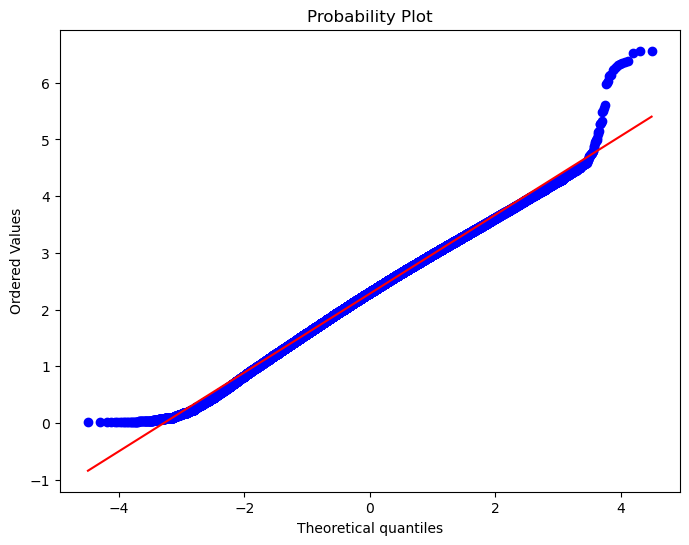

In [18]:
# Q-Q plot for checking if trip-times follow the log-normal distribution
ltt_sample = frame_with_durations_modified['log_times'].sample(n = 200000)

plt.figure(figsize = (8, 6))
scipy.stats.probplot(ltt_sample, plot = plt)

#### Observations:
- As can be seen from the above QQ-Plot, the 'trip_times', do not follow a log-normal distribution completely.
- From [-3 Std-Dev, +3 Std-Dev], it is more or less a log-normal distribution, but beyond that, the 'trip_times' differ from the log-normal distribution to some extent.

## 1.4. Speed

<Axes: ylabel='Speed'>

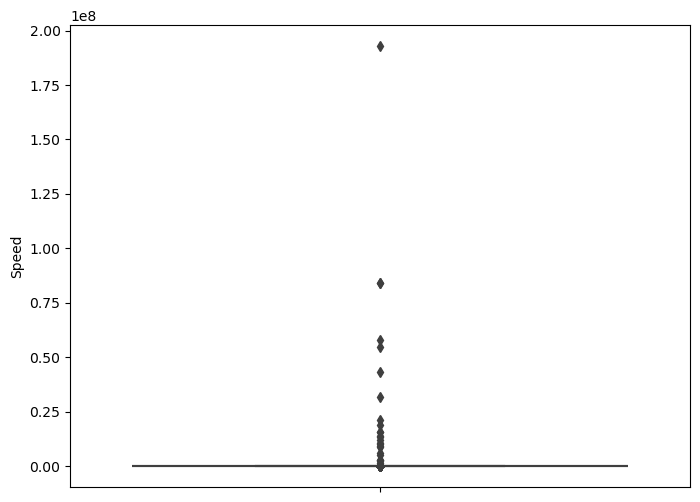

In [19]:
# Check for any outliers in the data after trip duration outliers have been removed
# Box-plot for speeds with outliers
frame_with_durations_modified['Speed'] = 60 * (frame_with_durations_modified['trip_distance'] / \
    frame_with_durations_modified['trip_times'])

plt.figure(figsize = (8, 6))
sns.boxplot(y="Speed", data = frame_with_durations_modified)

In [20]:
# Calculating speed values at each percentile: 0,10,20,30,40,50,60,70,80,90,100 
var = frame_with_durations_modified["Speed"].values
var = np.sort(var,axis = None)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.0
10 percentile value is 6.409495548961425
20 percentile value is 7.80952380952381
30 percentile value is 8.929133858267717
40 percentile value is 9.98019801980198
50 percentile value is 11.06865671641791
60 percentile value is 12.286689419795222
70 percentile value is 13.796407185628745
80 percentile value is 15.963224893917962
90 percentile value is 20.186915887850468
100 percentile value is  192857142.85714284


In [21]:
# Calculating speed values at each percentile: 90,91,92,93,94,95,96,97,98,99,100
var = frame_with_durations_modified["Speed"].values
var = np.sort(var,axis = None)
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 20.186915887850468
91 percentile value is 20.91645569620253
92 percentile value is 21.752988047808763
93 percentile value is 22.721893491124263
94 percentile value is 23.844155844155843
95 percentile value is 25.182552504038775
96 percentile value is 26.80851063829787
97 percentile value is 28.84304932735426
98 percentile value is 31.591128254580514
99 percentile value is 35.7513566847558
100 percentile value is  192857142.85714284


In [22]:
# Calculating speed values at each percentile: 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
var = frame_with_durations_modified["Speed"].values
var = np.sort(var,axis = None)
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 35.7513566847558
99.1 percentile value is 36.31084727468969
99.2 percentile value is 36.91470054446461
99.3 percentile value is 37.588235294117645
99.4 percentile value is 38.33035714285714
99.5 percentile value is 39.17580340264651
99.6 percentile value is 40.15384615384615
99.7 percentile value is 41.338301043219076
99.8 percentile value is 42.86631016042781
99.9 percentile value is 45.3107822410148
100 percentile value is  192857142.85714284


In [23]:
# Removing further outliers based on the 99.9th percentile value
frame_with_durations_modified = frame_with_durations[(frame_with_durations.Speed > 0) & \
    (frame_with_durations.Speed < 45.31)]

In [24]:
# Average speed of cabs in New-York
sum(frame_with_durations_modified["Speed"]) / float(len(frame_with_durations_modified["Speed"]))

12.450173996027528

#### Observations:
- The avg speed in Newyork speed is 12.45 miles/hr, so a cab driver can travel 2 miles per 10 min on an average.
- We will be using this observation in determining the time-bins and the regions. 

## 1.5. Trip Distance

<Axes: ylabel='trip_distance'>

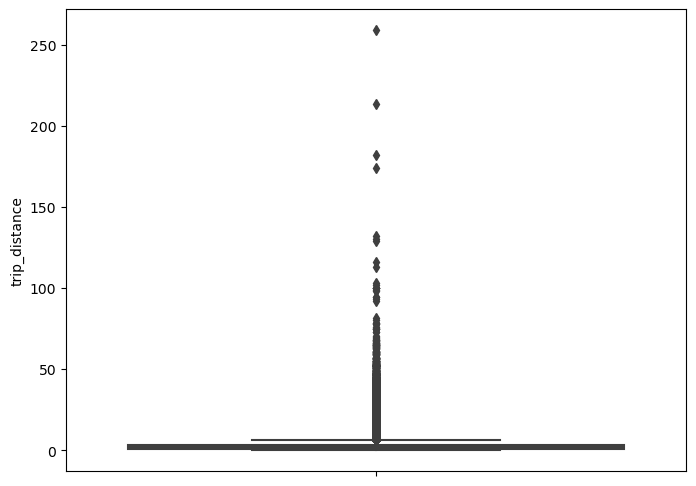

In [25]:
# Up to now, we have removed the outliers based on trip durations and cab speeds
# Let's try if there are any outliers in trip distances
# Box-plot showing outliers in trip-distance values

plt.figure(figsize = (8, 6))
sns.boxplot(y = "trip_distance", data = frame_with_durations_modified)

In [26]:
# Calculating trip distance values at each percentile: 0,10,20,30,40,50,60,70,80,90,100 
var = frame_with_durations_modified["trip_distance"].values
var = np.sort(var,axis = None)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is 0.01
10 percentile value is 0.66
20 percentile value is 0.9
30 percentile value is 1.1
40 percentile value is 1.39
50 percentile value is 1.69
60 percentile value is 2.07
70 percentile value is 2.6
80 percentile value is 3.6
90 percentile value is 5.97
100 percentile value is  258.9


In [27]:
# Calculating trip distance values at each percentile: 90,91,92,93,94,95,96,97,98,99,100
var = frame_with_durations_modified["trip_distance"].values
var = np.sort(var,axis = None)
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 5.97
91 percentile value is 6.45
92 percentile value is 7.07
93 percentile value is 7.85
94 percentile value is 8.72
95 percentile value is 9.6
96 percentile value is 10.6
97 percentile value is 12.1
98 percentile value is 16.03
99 percentile value is 18.17
100 percentile value is  258.9


In [28]:
# Calculating trip distance values at each percentile: 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
var = frame_with_durations_modified["trip_distance"].values
var = np.sort(var,axis = None)
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 18.17
99.1 percentile value is 18.37
99.2 percentile value is 18.6
99.3 percentile value is 18.83
99.4 percentile value is 19.13
99.5 percentile value is 19.5
99.6 percentile value is 19.96
99.7 percentile value is 20.5
99.8 percentile value is 21.22
99.9 percentile value is 22.57
100 percentile value is  258.9


In [29]:
# Removing further outliers based on the 99.9th percentile value
frame_with_durations_modified=frame_with_durations[(frame_with_durations.trip_distance > 0) & \
    (frame_with_durations.trip_distance < 23)]

<Axes: ylabel='trip_distance'>

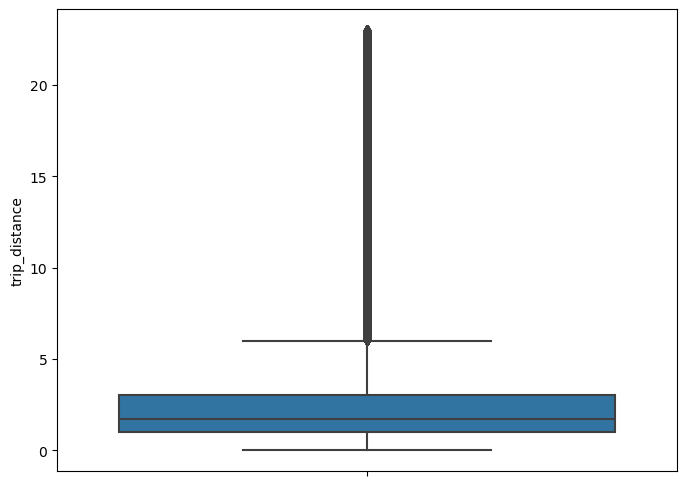

In [30]:
# Box-plot after removal of outliers
plt.figure(figsize = (8, 6))
sns.boxplot(y="trip_distance", data = frame_with_durations_modified)

## 1.6. Total Fare

<Axes: ylabel='total_amount'>

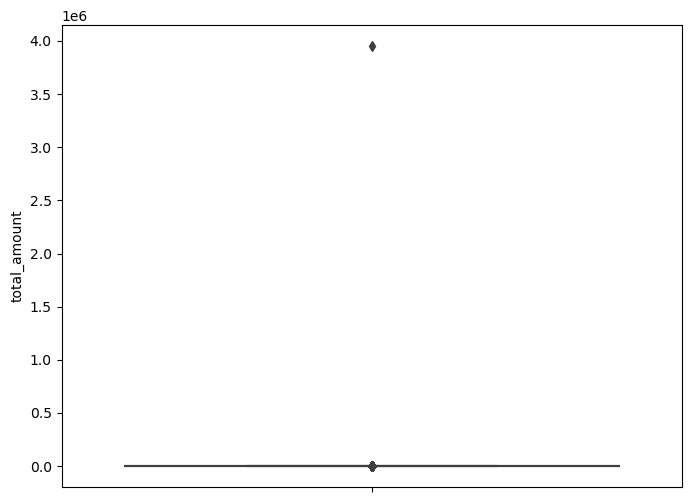

In [31]:
# Up to now we have removed the outliers based on trip durations, cab speeds, and trip distances
# Let's try if there are any outliers in the total_amount
# Box-plot showing outliers in fare
plt.figure(figsize = (8, 6))
sns.boxplot(y="total_amount", data = frame_with_durations_modified)

In [32]:
# Calculating total fare amount values at each percentile: 0,10,20,30,40,50,60,70,80,90,100 
var = frame_with_durations_modified["total_amount"].values
var = np.sort(var,axis = None)
for i in range(0,100,10):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

0 percentile value is -242.55
10 percentile value is 6.3
20 percentile value is 7.8
30 percentile value is 8.8
40 percentile value is 9.8
50 percentile value is 11.16
60 percentile value is 12.8
70 percentile value is 14.8
80 percentile value is 18.3
90 percentile value is 25.8
100 percentile value is  3950611.6


In [33]:
# Calculating total fare amount values at each percentile: 90,91,92,93,94,95,96,97,98,99,100
var = frame_with_durations_modified["total_amount"].values
var = np.sort(var,axis = None)
for i in range(90,100):
    print("{} percentile value is {}".format(i,var[int(len(var)*(float(i)/100))]))
print("100 percentile value is ",var[-1])

90 percentile value is 25.8
91 percentile value is 27.3
92 percentile value is 29.3
93 percentile value is 31.8
94 percentile value is 34.8
95 percentile value is 38.53
96 percentile value is 42.6
97 percentile value is 48.13
98 percentile value is 58.13
99 percentile value is 66.13
100 percentile value is  3950611.6


In [34]:
# Calculating total fare amount values at each percentile: 99.0,99.1,99.2,99.3,99.4,99.5,99.6,99.7,99.8,99.9,100
var = frame_with_durations_modified["total_amount"].values
var = np.sort(var,axis = None)
for i in np.arange(0.0, 1.0, 0.1):
    print("{} percentile value is {}".format(99+i,var[int(len(var)*(float(99+i)/100))]))
print("100 percentile value is ",var[-1])

99.0 percentile value is 66.13
99.1 percentile value is 68.13
99.2 percentile value is 69.6
99.3 percentile value is 69.6
99.4 percentile value is 69.73
99.5 percentile value is 69.75
99.6 percentile value is 69.76
99.7 percentile value is 72.58
99.8 percentile value is 75.35
99.9 percentile value is 88.28
100 percentile value is  3950611.6


#### Observations:
- As even the 99.9th percentile value doesnt look like an outlier, as there is not much difference between the 99.8th percentile and 99.9th percentile, we move on to do graphical analyis from the numerical analysis, we have been doing so far.

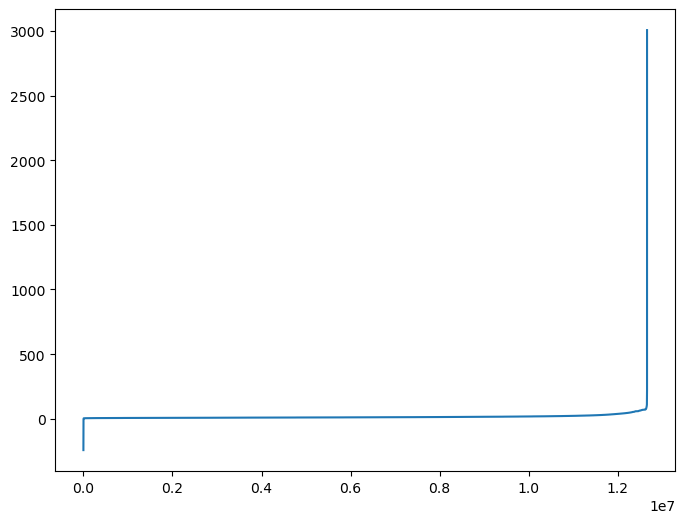

In [35]:
# The below plot shows us the fare values (sorted) to find a sharp increase, to remove those values 
# as outliers. Plot the fare amount excluding the last two values in sorted data
plt.figure(figsize = (8, 6))
plt.plot(var[:-2])
plt.show()

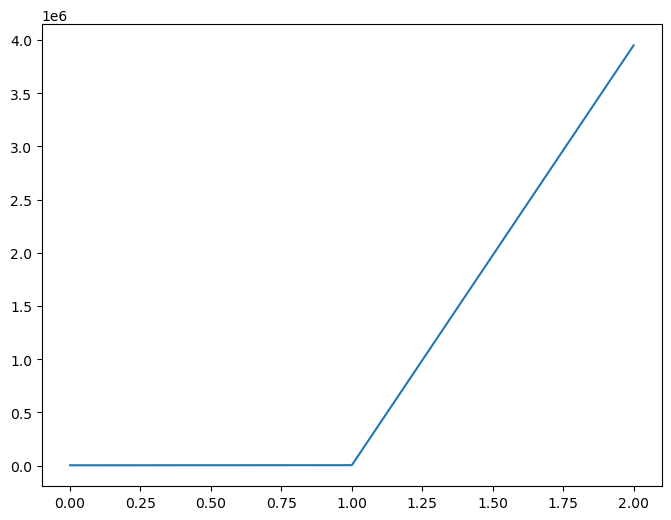

In [36]:
# A very sharp increase in fare values can be seen. Plotting last three total fare values
# And we can observe that there is a shared increase in the values
plt.figure(figsize = (8, 6))
plt.plot(var[-3:])
plt.show()

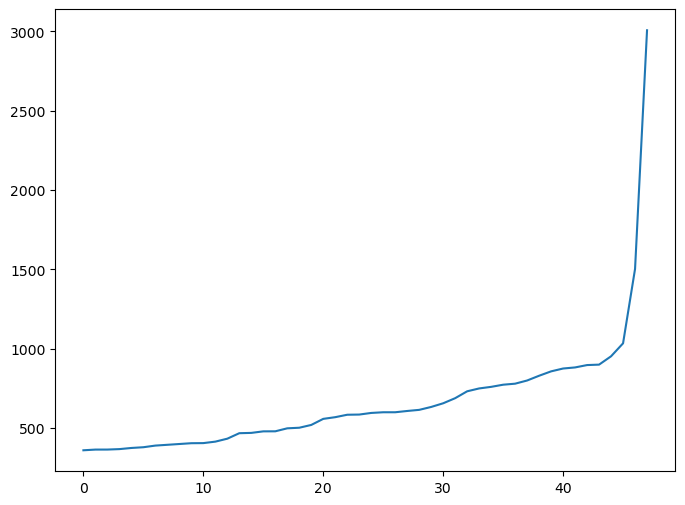

In [37]:
# Now looking at values not including the last two points, we again find a drastic increase at 
# around 1000 fare values. We plot the last 50 values, excluding the last two values
plt.figure(figsize = (8, 6))
plt.plot(var[-50:-2])
plt.show()

## 1.7. Remove all outlier/erroneous points
- Based upon the numerical/graphical univariate analysis, we performed with the *pickup coordinates, dropoff coordinates, trip durations, trip distances, speeds and total fares*, we will make a function to apply all those pre-processing steps.

In [38]:
# Removing all outliers based on our univariate analysis above
def remove_outliers(new_frame):
    a = new_frame.shape[0]
    print("Number of pickup records:", a)
    
    temp_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
        (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
        ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
        (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    b = temp_frame.shape[0]
    print("Number of outlier coordinates lying outside NY boundaries:", (a-b))

    temp_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    c = temp_frame.shape[0]
    print("Number of outliers from trip times analysis:", (a-c))
    
    temp_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    d = temp_frame.shape[0]
    print ("Number of outliers from trip distance analysis:", (a-d))
    
    temp_frame = new_frame[(new_frame.Speed <= 45.31) & (new_frame.Speed >= 0)]
    e = temp_frame.shape[0]
    print ("Number of outliers from speed analysis:", (a-e))
    
    temp_frame = new_frame[(new_frame.total_amount < 1000) & (new_frame.total_amount > 0)]
    f = temp_frame.shape[0]
    print ("Number of outliers from fare analysis:", (a-f))
    
    
    new_frame = new_frame[((new_frame.dropoff_longitude >= -74.15) & (new_frame.dropoff_longitude <= -73.7004) &\
        (new_frame.dropoff_latitude >= 40.5774) & (new_frame.dropoff_latitude <= 40.9176)) & \
        ((new_frame.pickup_longitude >= -74.15) & (new_frame.pickup_latitude >= 40.5774)& \
        (new_frame.pickup_longitude <= -73.7004) & (new_frame.pickup_latitude <= 40.9176))]
    new_frame = new_frame[(new_frame.trip_times > 0) & (new_frame.trip_times < 720)]
    new_frame = new_frame[(new_frame.trip_distance > 0) & (new_frame.trip_distance < 23)]
    new_frame = new_frame[(new_frame.Speed < 45.31) & (new_frame.Speed > 0)]
    new_frame = new_frame[(new_frame.total_amount < 1000) & (new_frame.total_amount > 0)]
    
    print ("Total outliers removed", a-new_frame.shape[0])
    return new_frame

In [39]:
print ("Removing outliers in the month of Jan-2015")
frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
print("Fraction of data points that remain after removing outliers", 
    float(len(frame_with_durations_outliers_removed)) / len(frame_with_durations))

Removing outliers in the month of Jan-2015
Number of pickup records: 12748986
Number of outlier coordinates lying outside NY boundaries: 293919
Number of outliers from trip times analysis: 23889
Number of outliers from trip distance analysis: 92597
Number of outliers from speed analysis: 36690
Number of outliers from fare analysis: 5275
Total outliers removed 377910
Fraction of data points that remain after removing outliers 0.9703576425607495


# 2. Data Preparation
## 2.1. Clustering/Segmentation
- While clustering, the inter-cluster distance for considering 2 clusters to be in the vicinity of each other is set as **2 miles**.
- In section 1.4, we observed that on an average, a cabbie can cover 2 miles in approximately 10 mins, and since, 2 miles is an acceptable distance to find more #pickups, hence, we have set the 2 miles threshold.
- We need to choose number of clusters so that, there are more number of cluster regions that are close to any cluster center and make sure that the minimum inter-cluster distance should not be very less.

In [40]:
# Trying different cluster sizes to choose the right K in K-means
coords = frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']].values
neighbours = []
 
def find_min_distance(cluster_centers, cluster_len):
    nice_points = 0
    wrong_points = 0
    less2 = []
    more2 = []
    # Stored & Calculated in miles
    min_dist = 1000
    
    for i in range(0, cluster_len):
        nice_points = 0
        wrong_points = 0
        for j in range(0, cluster_len):
            if j != i:
                distance = gpxpy.geo.haversine_distance(cluster_centers[i][0], cluster_centers[i][1],
                    cluster_centers[j][0], cluster_centers[j][1])
                # `distance` is in meters, so, we have converted it into miles
                min_dist = min(min_dist, distance/(1.60934*1000))
                if (distance/(1.60934*1000)) <= 2: nice_points += 1
                else: wrong_points += 1
        less2.append(nice_points)
        more2.append(wrong_points)
    neighbours.append(less2)
    print ("On choosing a cluster size of:", cluster_len, "\nAvg. #Clusters within the vicinity (i.e. intercluster-distance < 2):", 
        np.ceil(sum(less2)/len(less2)), "\nAvg. #Clusters outside the vicinity (i.e. intercluster-distance > 2):", 
        np.ceil(sum(more2)/len(more2)), "\nMin inter-cluster distance:", min_dist, "\n")

# https://scikit-learn.org/stable/modules/clustering.html#mini-batch-kmeans
def find_clusters(increment):
    kmeans = MiniBatchKMeans(n_clusters=increment, batch_size=10000, random_state=42).fit(coords)
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])
    cluster_centers = kmeans.cluster_centers_
    cluster_len = len(cluster_centers)
    return cluster_centers, cluster_len

for increment in range(10, 100, 10):
    cluster_centers, cluster_len = find_clusters(increment)
    find_min_distance(cluster_centers, cluster_len)            

On choosing a cluster size of: 10 
Avg. #Clusters within the vicinity (i.e. intercluster-distance < 2): 2.0 
Avg. #Clusters outside the vicinity (i.e. intercluster-distance > 2): 8.0 
Min inter-cluster distance: 0.9403042157013325 

On choosing a cluster size of: 20 
Avg. #Clusters within the vicinity (i.e. intercluster-distance < 2): 4.0 
Avg. #Clusters outside the vicinity (i.e. intercluster-distance > 2): 15.0 
Min inter-cluster distance: 0.6591575997035559 

On choosing a cluster size of: 30 
Avg. #Clusters within the vicinity (i.e. intercluster-distance < 2): 8.0 
Avg. #Clusters outside the vicinity (i.e. intercluster-distance > 2): 22.0 
Min inter-cluster distance: 0.4816324407604508 

On choosing a cluster size of: 40 
Avg. #Clusters within the vicinity (i.e. intercluster-distance < 2): 11.0 
Avg. #Clusters outside the vicinity (i.e. intercluster-distance > 2): 29.0 
Min inter-cluster distance: 0.45331676035418483 

On choosing a cluster size of: 50 
Avg. #Clusters within the vi

#### Inference:
- The main objective was to find a optimal min. distance (which roughly estimates to the radius of a cluster) between the clusters, and we got it as 40.
- If we check for 50 clusters, we can observe that there are two clusters which are only 0.3 miles apart from each other, so, we choose 40 clusters to solve the further problems.

In [41]:
# Getting 40 clusters using K-Means
kmeans = MiniBatchKMeans(n_clusters=40, batch_size=10000, random_state=0).fit(coords)
frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

### 2.1.1. Plotting the Cluster Centers

In [42]:
# Plotting the cluster centers on OSM
cluster_centers = kmeans.cluster_centers_
cluster_len = len(cluster_centers)
map_osm = folium.Map(location = [40.734695, -73.990372], tiles='OpenStreetMap')
for i in range(cluster_len):
    folium.Marker(list((cluster_centers[i][0], cluster_centers[i][1])), 
        popup=(str(cluster_centers[i][0])+str(cluster_centers[i][1]))).add_to(map_osm)
map_osm

### 2.1.2. Plotting the Clusters

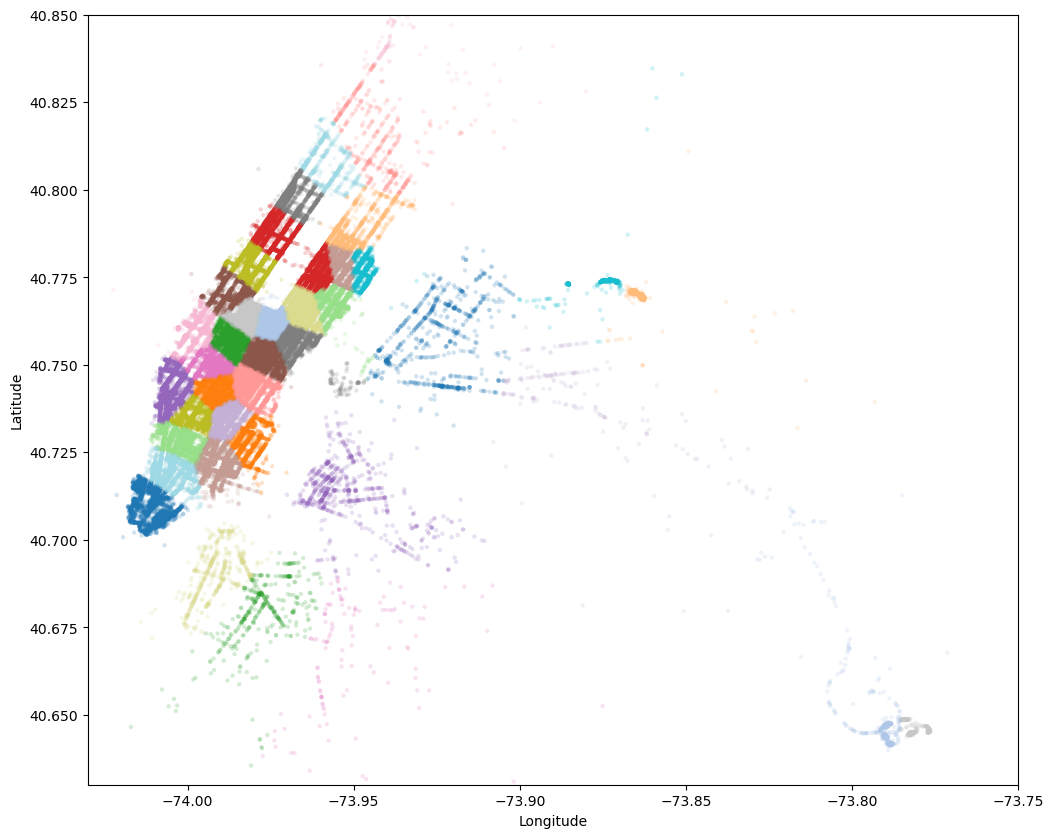

In [43]:
# Visualising the clusters on a map
def plot_clusters(frame):
    city_long_border = (-74.03, -73.75)
    city_lat_border = (40.63, 40.85)
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize = (12, 10))
    ax.scatter(frame.pickup_longitude.values[:100000], frame.pickup_latitude.values[:100000], s=10, 
        lw=0, c=frame.pickup_cluster.values[:100000], cmap='tab20', alpha=0.2)
    ax.set_xlim(city_long_border)
    ax.set_ylim(city_lat_border)
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    plt.show()

plot_clusters(frame_with_durations_outliers_removed)

## 2.2. Time Binning
- Reference for Unix Time-Stamp: https://www.unixtimestamp.com/
- Reference for EST: https://www.timeanddate.com/time/zones/est

In [44]:
def add_pickup_bins(frame, month, year):
    unix_pickup_times = [i for i in frame['pickup_times'].values]
    unix_times = [[1420070400,1422748800,1425168000,1427846400,1430438400,1433116800],\
                    [1451606400,1454284800,1456790400,1459468800,1462060800,1464739200]]
    start_pickup_unix = unix_times[year-2015][month-1]
    
    tenminutewise_binned_unix_pickup_times=[(int((i-start_pickup_unix)/600)+33) for i in unix_pickup_times]
    frame['pickup_bins'] = np.array(tenminutewise_binned_unix_pickup_times)
    return frame

In [45]:
# Clustering, making pickup bins and grouping by pickup cluster and pickup bins
jan_2015_frame = add_pickup_bins(frame_with_durations_outliers_removed,1,2015)
jan_2015_groupby = jan_2015_frame[['pickup_cluster','pickup_bins','trip_distance']] \
    .groupby(['pickup_cluster','pickup_bins']).count()
jan_2015_groupby = jan_2015_groupby.rename(columns = {'trip_distance': 'pickups'})

- We have added 2 more columns 'pickup_cluster' (to which cluster it belongs to) and 'pickup_bins' (to which 10 min interval the trip belongs to)
- Here, the 'pickups' represents the number of pickups that happened in that particular 10-min interval. 
- This data frame has two indices
    - Primary Index: pickup_cluster (Cluster Number)
    - Secondary Index : pickup_bins (We have divided the entire month's time into 10-min intervals 31\*24\*60/10 = 4464bins)
- Upto now, we have cleaned and prepared the data for Jan 2015. Now, we will do the same operations for months Jan, Feb, March of 2016
1. Get the dataframe which includes only required colums
2. Adding trip times, speed, unix time-stamp of pickup_time
4. Remove the outliers based on trip_times, speed, trip_duration, total_amount
5. Add pickup_cluster to each data point
6. Add pickup_bin (index of 10-min interval to which that trip belongs to)
7. Group by data, based on 'pickup_cluster' and 'pickup_bin'

In [46]:
# Data Preparation for the months of Jan,Feb and March 2016
# Here, `month` refers to the Dask Dataframe
def datapreparation(month, kmeans, month_no, year_no):
    # Add the trip-times
    frame_with_durations = return_with_trip_times(month)
    
    # Remove the outliers
    frame_with_durations_outliers_removed = remove_outliers(frame_with_durations)
    print("\n")
    
    # Estimating Clusters
    frame_with_durations_outliers_removed['pickup_cluster'] = kmeans.predict(frame_with_durations_outliers_removed[['pickup_latitude', 'pickup_longitude']])

    # Performing the Group-By operation
    final_updated_frame = add_pickup_bins(frame_with_durations_outliers_removed, month_no, year_no)
    final_groupby_frame = final_updated_frame[['pickup_cluster','pickup_bins','trip_distance']].groupby(['pickup_cluster','pickup_bins']).count()
    final_groupby_frame = final_groupby_frame.rename(columns = {'trip_distance': 'pickups'})
    return final_updated_frame, final_groupby_frame

dtype_dict = {
    'tip_amount': 'float64',
    'tolls_amount': 'float64'
}
month_jan_2016 = dd.read_csv('yellow_tripdata_2016-01.csv',dtype=dtype_dict)
month_feb_2016 = dd.read_csv('yellow_tripdata_2016-02.csv',dtype=dtype_dict)
month_mar_2016 = dd.read_csv('yellow_tripdata_2016-03.csv',dtype=dtype_dict)

jan_2016_frame, jan_2016_groupby = datapreparation(month_jan_2016, kmeans, 1, 2016)
feb_2016_frame, feb_2016_groupby = datapreparation(month_feb_2016, kmeans, 2, 2016)
mar_2016_frame, mar_2016_groupby = datapreparation(month_mar_2016, kmeans, 3, 2016)

Number of pickup records: 10906858
Number of outlier coordinates lying outside NY boundaries: 214677
Number of outliers from trip times analysis: 27190
Number of outliers from trip distance analysis: 79742
Number of outliers from speed analysis: 31018
Number of outliers from fare analysis: 4991
Total outliers removed 297784


Number of pickup records: 11382049
Number of outlier coordinates lying outside NY boundaries: 223161
Number of outliers from trip times analysis: 27670
Number of outliers from trip distance analysis: 81902
Number of outliers from speed analysis: 31866
Number of outliers from fare analysis: 5476
Total outliers removed 308177


Number of pickup records: 12210952
Number of outlier coordinates lying outside NY boundaries: 232444
Number of outliers from trip times analysis: 30868
Number of outliers from trip distance analysis: 87318
Number of outliers from speed analysis: 33076
Number of outliers from fare analysis: 5859
Total outliers removed 324635




## 2.3. Smoothing
- Get the unique bins where pickup values are present for each region
- For each cluster region, we will collect all the indices of 10-min intervals, in which at least 1 pickup has happened. We got an observation that there are some pickup bins that doesn't have any pickups.

In [47]:
def return_unq_pickup_bins(frame):
    values = []
    for i in range(0,40):
        new = frame[frame['pickup_cluster'] == i]
        list_unq = list(set(new['pickup_bins']))
        list_unq.sort()
        values.append(list_unq)
    return values

In [48]:
# For every month, we get all indices of 10-min intervals in which atleast one pickup happened
jan_2015_unique = return_unq_pickup_bins(jan_2015_frame)
jan_2016_unique = return_unq_pickup_bins(jan_2016_frame)
feb_2016_unique = return_unq_pickup_bins(feb_2016_frame)
mar_2016_unique = return_unq_pickup_bins(mar_2016_frame)

In [49]:
# For each cluster, number of 10-min intervals with 0 pickups
for i in range(40):
    print("For the", i, "th cluster, number of 10-min intervals with 0 pickups:", 4464 - len(set(jan_2015_unique[i])))

For the 0 th cluster, number of 10-min intervals with 0 pickups: 38
For the 1 th cluster, number of 10-min intervals with 0 pickups: 29
For the 2 th cluster, number of 10-min intervals with 0 pickups: 38
For the 3 th cluster, number of 10-min intervals with 0 pickups: 410
For the 4 th cluster, number of 10-min intervals with 0 pickups: 42
For the 5 th cluster, number of 10-min intervals with 0 pickups: 36
For the 6 th cluster, number of 10-min intervals with 0 pickups: 30
For the 7 th cluster, number of 10-min intervals with 0 pickups: 587
For the 8 th cluster, number of 10-min intervals with 0 pickups: 32
For the 9 th cluster, number of 10-min intervals with 0 pickups: 105
For the 10 th cluster, number of 10-min intervals with 0 pickups: 35
For the 11 th cluster, number of 10-min intervals with 0 pickups: 32
For the 12 th cluster, number of 10-min intervals with 0 pickups: 68
For the 13 th cluster, number of 10-min intervals with 0 pickups: 44
For the 14 th cluster, number of 10-min i

#### Now, there are two ways to fill up these values:
- Fill the missing value with 0's
- Fill the missing values with the avg values
    - Case 1: (Values missing at the start)
        - _ _ _ x => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) 
        - _ _ x => ceil(x/3), ceil(x/3), ceil(x/3)
    - Case 2: (Values missing in middle) 
        - x _ _ y => ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4), ceil((x+y)/4) 
        - x _ _ _ y => ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5), ceil((x+y)/5)
    - Case 3: (Values missing at the end)  
        - x _ _ _  => ceil(x/4), ceil(x/4), ceil(x/4), ceil(x/4) 
        - x _  => ceil(x/2), ceil(x/2)

In [50]:
# Fills a value of 0 for every bin, where no pickup data is present 
# count_values: #pickps that happened in each region for each 10-min interval
# There won't be any value if there are no pickups
# values: Unique bins' indices for every cluster

# For every 10-min interval (pickup_bin), we will check if it is there in our unique bin
# If it is there, we will add the count_values[index] to smoothed data
# If not, we will add 0 to the smoothed data
# We finally return smoothed data

def fill_missing(count_values, values):
    smoothed_regions = []
    ind = 0
    for r in range(0,40):
        smoothed_bins = []
        for i in range(4464):
            if i in values[r]:
                smoothed_bins.append(count_values[ind])
                ind += 1
            else:
                smoothed_bins.append(0)
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [51]:
# Fills the average value for every bin, where no pickup data is present 
# count_values: #pickps that happened in each region for each 10-min interval
# There won't be any value if there are no pickups
# values: Unique bins' indices for every cluster

# For every 10-min interval (pickup_bin), we will check if it is there in our unique bin
# If it is there, we will add the count_values[index] to smoothed data
# If not, we will add smoothed data (which is calculated based on the methods that are discussed 
# in the above markdown cell), and then, we finally return the smoothed data

def smoothing(count_values,values):
    # Stores list of final smoothed values of each region
    smoothed_regions = [] 
    ind = 0
    repeat = 0 
    smoothed_value = 0
    for r in range(0,40):
        smoothed_bins = [] # Stores the final smoothed values
        repeat = 0
        for i in range(4464):
            # Prevents iteration for a value which is already visited/resolved
            if repeat != 0: repeat -= 1; continue
            
            # Checks if the pickup-bin exists. Appends the value of the pickup bin if it exists
            if i in values[r]: smoothed_bins.append(count_values[ind]) 
                
            # If the pickup bin doesn't exist
            else:
                if i != 0:
                    right_hand_limit = 0
                    for j in range(i, 4464):
                        # Searches for the left-limit or the pickup-bin value which has a pickup value
                        if  j not in values[r]: continue
                        else: right_hand_limit = j; break
                    # Case 1: When we have the last/last few values are found to be missing, & hence we have no right-limit here
                    if right_hand_limit == 0:
                        smoothed_value = count_values[ind-1]*1.0 / ((4463-i)+2)*1.0                               
                        for j in range(i, 4464):                              
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat = (4463-i)
                        ind -= 1
                    else:
                    # Case 2: When we have the missing values between two known values
                        smoothed_value = (count_values[ind-1] + count_values[ind])*1.0 / ((right_hand_limit-i)+2)*1.0             
                        for j in range(i, right_hand_limit+1):
                            smoothed_bins.append(math.ceil(smoothed_value))
                        smoothed_bins[i-1] = math.ceil(smoothed_value)
                        repeat=(right_hand_limit-i)
                else:
                    # Case 3: When we have the first/first few values are found to be missing, hence we have no left-limit here
                    right_hand_limit = 0
                    for j in range(i,4464):
                        if j not in values[r]: continue
                        else: right_hand_limit = j; break
                    smoothed_value = count_values[ind]*1.0 / ((right_hand_limit-i)+1)*1.0
                    for j in range(i, right_hand_limit+1):
                        smoothed_bins.append(math.ceil(smoothed_value))
                    repeat = (right_hand_limit - i)
            ind += 1
        smoothed_regions.extend(smoothed_bins)
    return smoothed_regions

In [52]:
# Filling Missing values of Jan-2015 with 0
jan_2015_fill = fill_missing(jan_2015_groupby['pickups'].values, jan_2015_unique)

# Smoothing Missing values of Jan-2015
jan_2015_smooth = smoothing(jan_2015_groupby['pickups'].values, jan_2015_unique)

In [53]:
# Number of 10-min indices for Jan 2015: 24*31*60/10 = 4464
# Number of 10-min indices for Jan 2016: 24*31*60/10 = 4464
# Number of 10-min indices for Feb 2016: 24*29*60/10 = 4176
# Number of 10-min indices for Mar 2016: 24*31*60/10 = 4464
# For each cluster we will have 4464 values, therefore 40*4464 = 178560 (Length of the jan_2015_fill)
print("Number of 10-min intervals among all the clusters:", len(jan_2015_fill))

Number of 10-min intervals among all the clusters: 178560


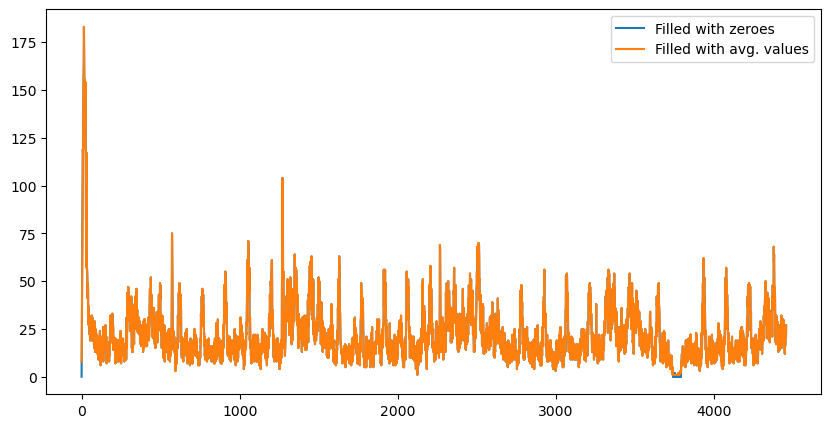

In [54]:
# Smoothing vs Filling
# Sample plot that shows two variations of filling missing values
# We have taken the #pickups for cluster region 2
plt.figure(figsize = (10,5))
plt.plot(jan_2015_fill[4464:8920], label="Filled with zeroes")
plt.plot(jan_2015_smooth[4464:8920], label="Filled with avg. values")
plt.legend()
plt.show()

#### Why we choose these methods and which method will be used for which data?

- Consider we have data of some time-bin in 1st Jan 2015, 10 _ _ _ 20, i.e., 10 pickups happened in 0th 10-min interval, 0 pickup happened in 1st, 2nd & 3rd 10-min interval, and 20 pickups happened in 4th 10-min interval
- In ***fill_missing*** method, we replace these values like 10, 0, 0, 0, 20, where as in ***smoothing*** method, we replace these values as 6, 6, 6, 6, 6.
- If you can check the #pickups that happened in the first 50-min, they are same in both the cases, but if you can observe, we are looking at the future values when we are using smoothing, i.e., we are looking at the future #pickups,  which might cause a data leakage.
- So, we use smoothing for Jan 2015 data, since it acts as our training data, and we use simple fill_misssing method for 2016 data.

In [55]:
# Jan-2015 data is smoothed, Jan, Feb & Mar 2016 data missing values are filled with zeroes
jan_2015_smooth = smoothing(jan_2015_groupby['pickups'].values, jan_2015_unique)
jan_2016_smooth = fill_missing(jan_2016_groupby['pickups'].values, jan_2016_unique)
feb_2016_smooth = fill_missing(feb_2016_groupby['pickups'].values, feb_2016_unique)
mar_2016_smooth = fill_missing(mar_2016_groupby['pickups'].values, mar_2016_unique)

# Making list of all the values of pickup data in every bin for a period of 3 months, 
# and storing them region-wise. 
# regions_cum: It will contain 40 lists, each list will contain 4464 + 4176 + 4464 values,
# which represents the #pickups, that have happened for three months in 2016 data
regions_cum = []

# Number of 10-min indices for Jan 2015: 24*31*60/10 = 4464
# Number of 10-min indices for Jan 2016: 24*31*60/10 = 4464
# Number of 10-min indices for Feb 2016: 24*29*60/10 = 4176
# Number of 10-min indices for Mar 2016: 24*31*60/10 = 4464

for i in range(0, 40):
    regions_cum.append(jan_2016_smooth[4464*i:4464*(i+1)] + feb_2016_smooth[4176*i:4176*(i+1)] + \
        mar_2016_smooth[4464*i:4464*(i+1)])

print(len(regions_cum), len(regions_cum[0]))

40 13104


## 2.4. Time series and Fourier Transforms
- Getting Peaks: https://blog.ytotech.com/2015/11/01/findpeaks-in-python/
- FFT Function: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fft.html
- FFTfreq: https://docs.scipy.org/doc/numpy/reference/generated/numpy.fft.fftfreq.html 

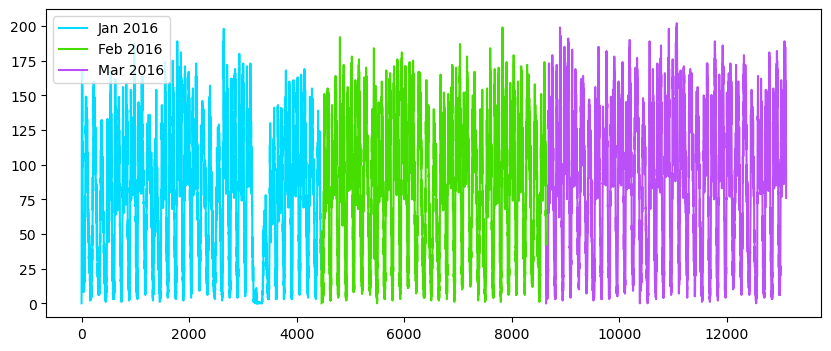

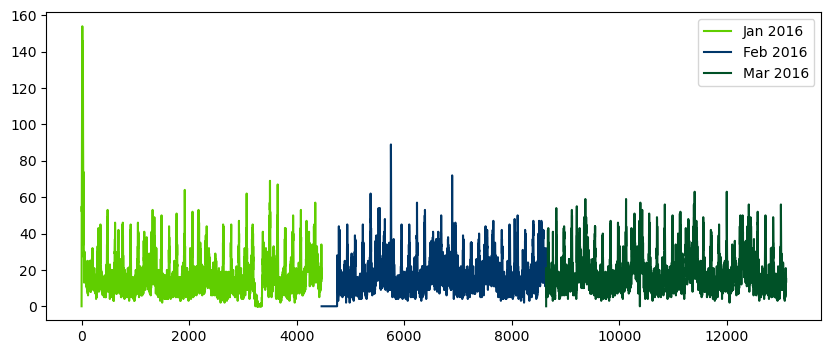

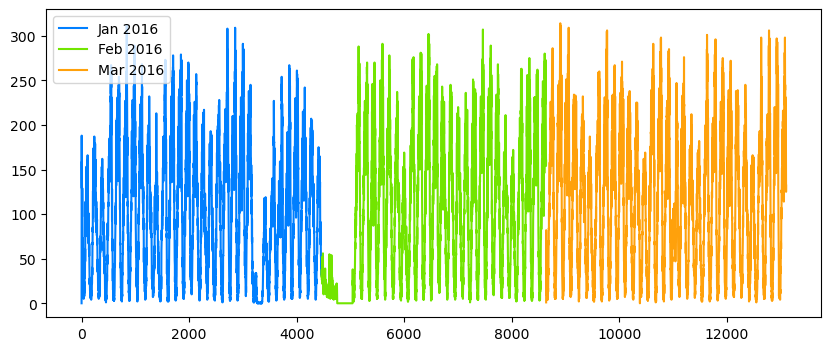

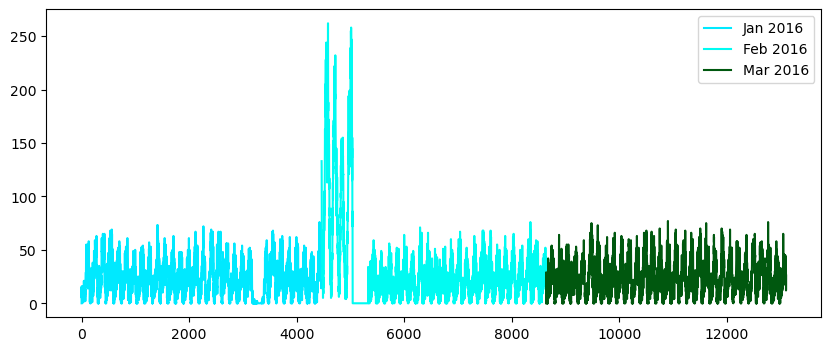

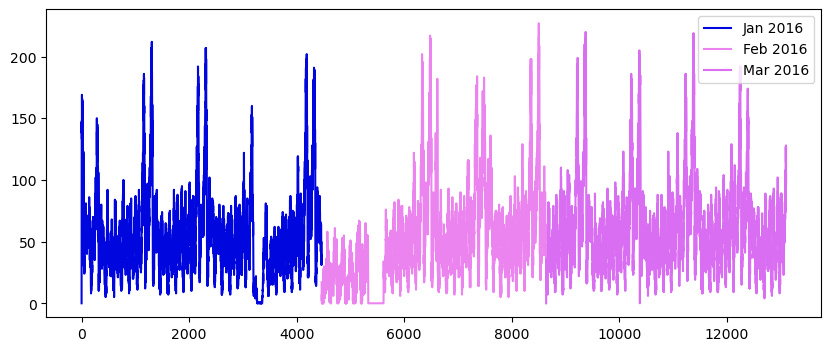

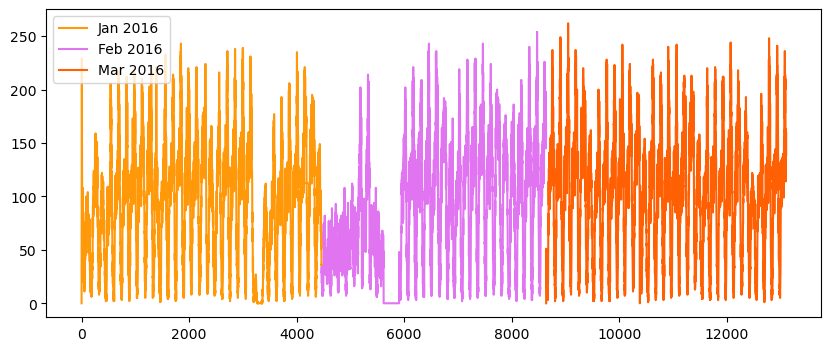

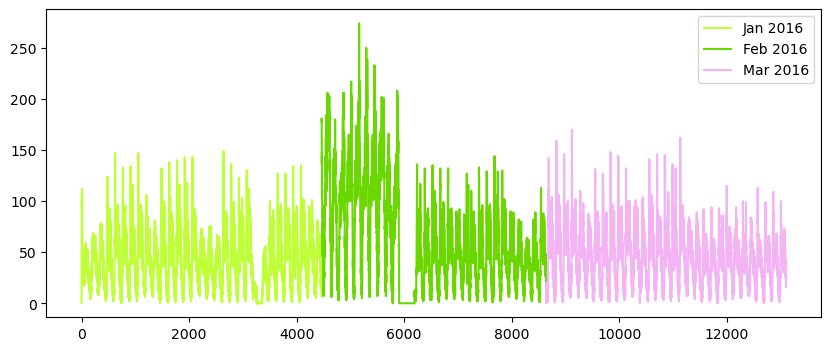

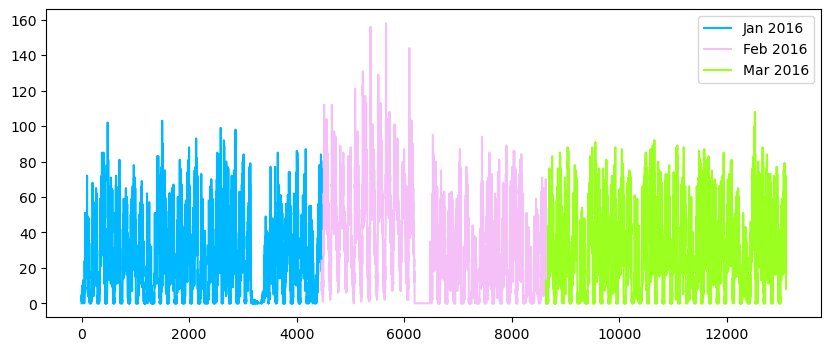

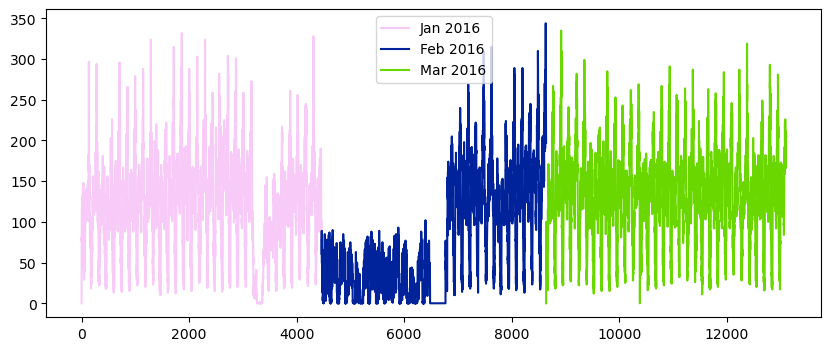

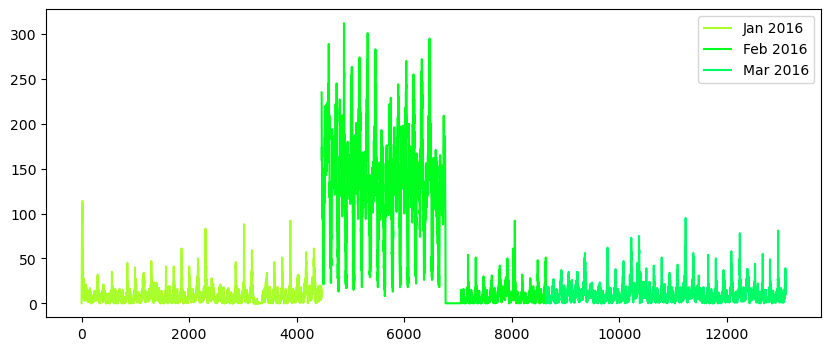

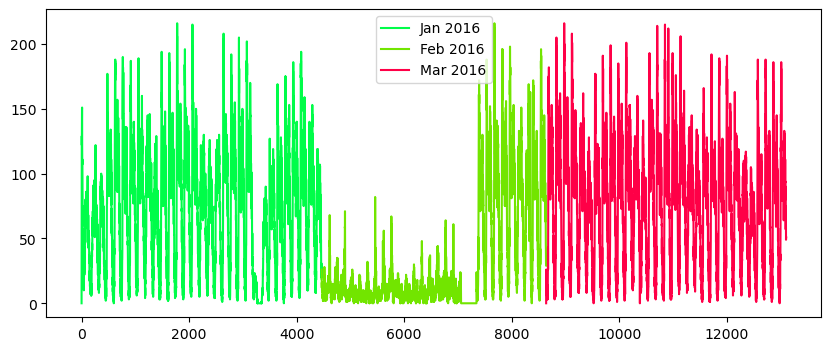

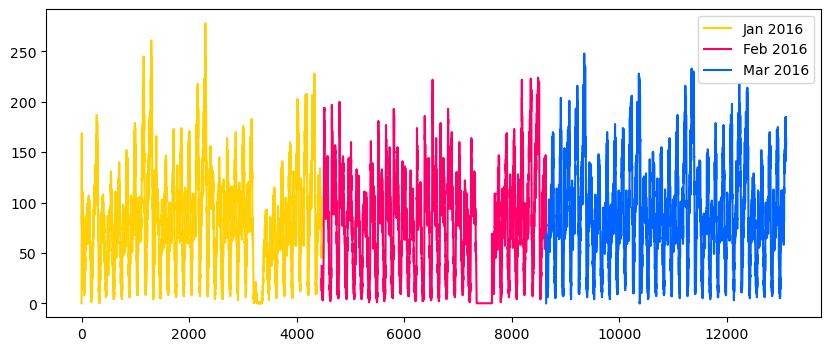

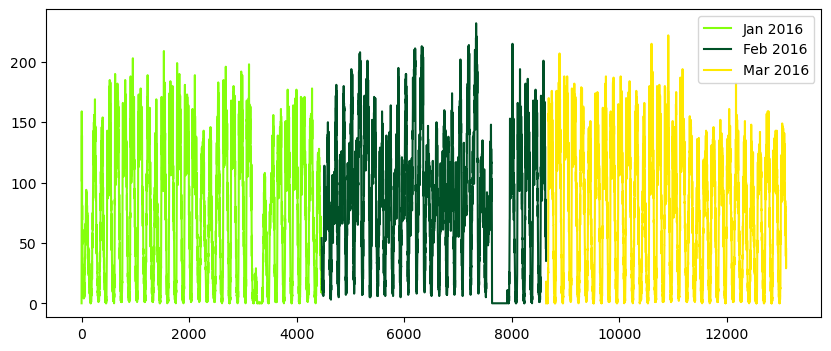

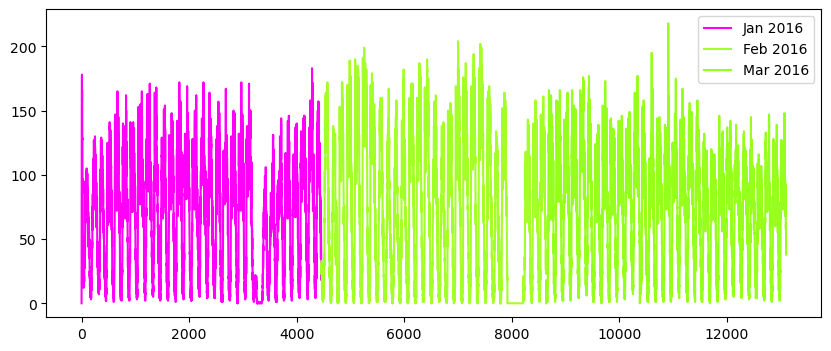

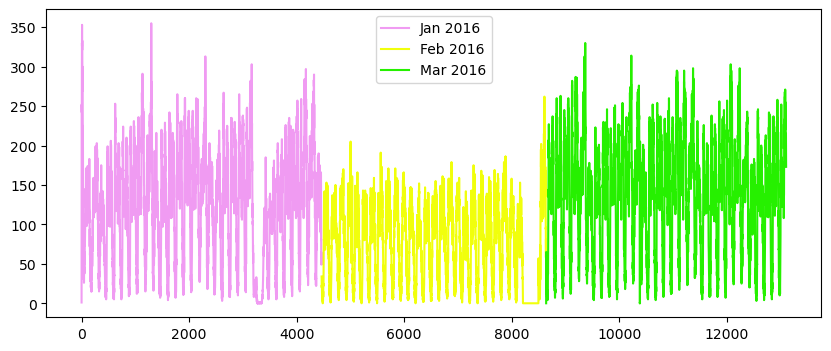

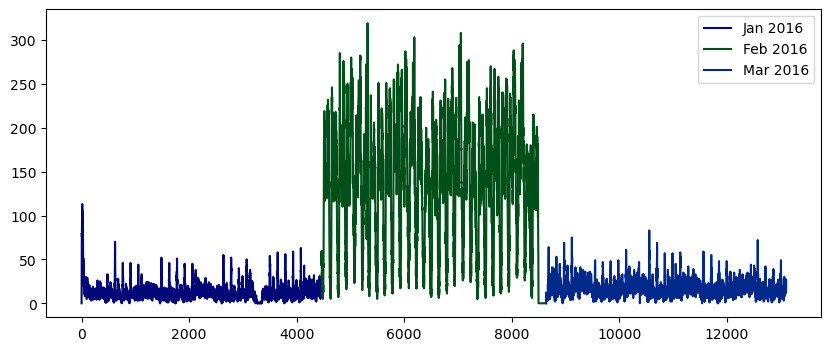

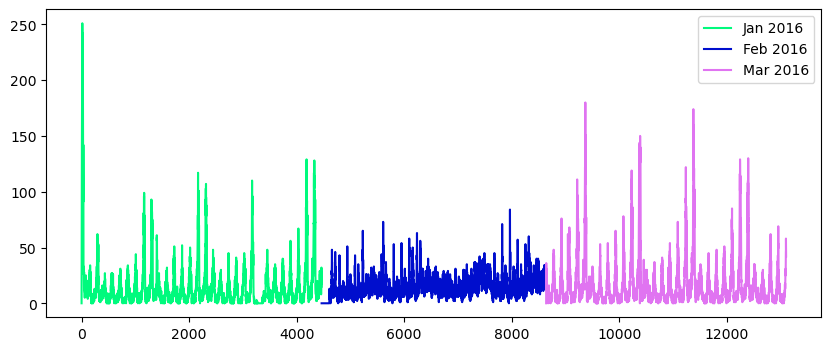

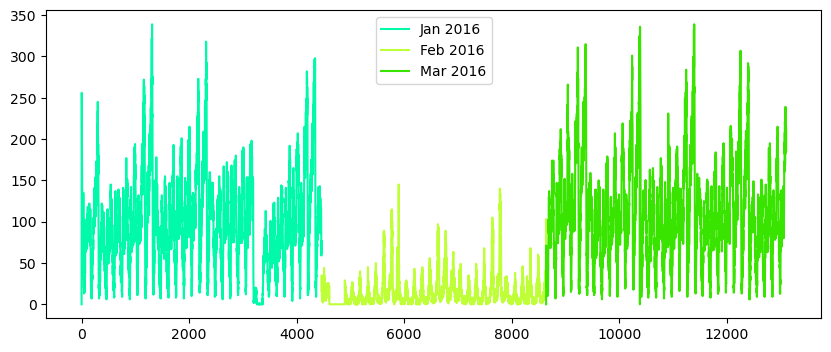

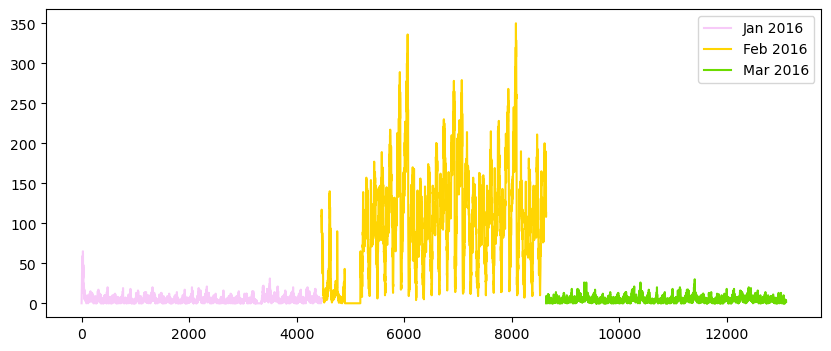

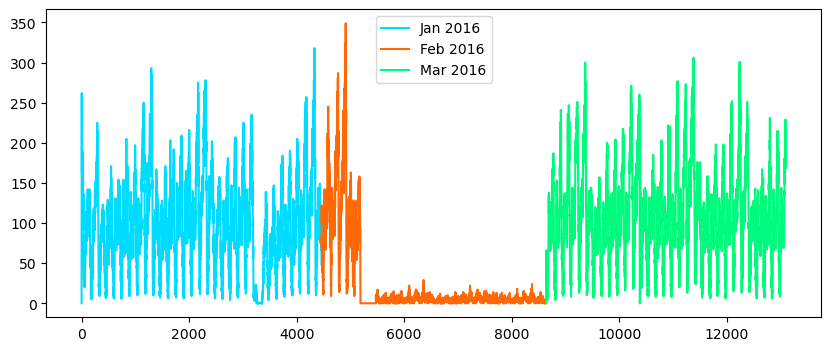

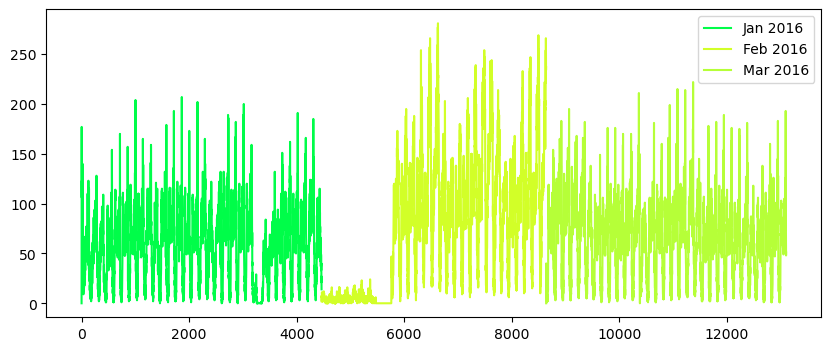

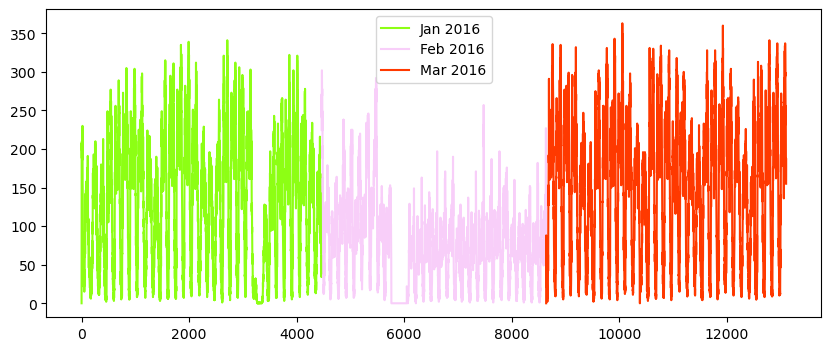

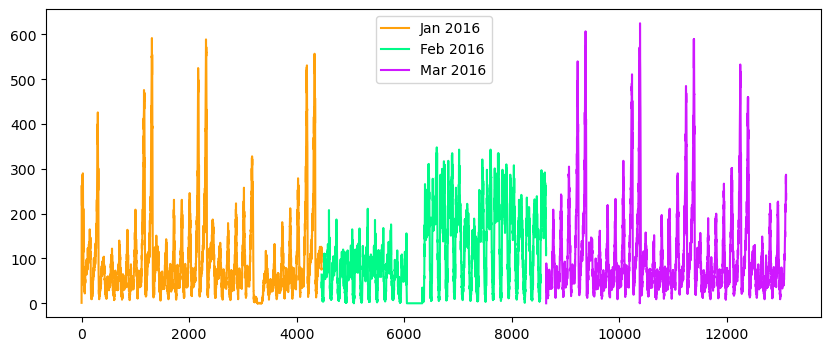

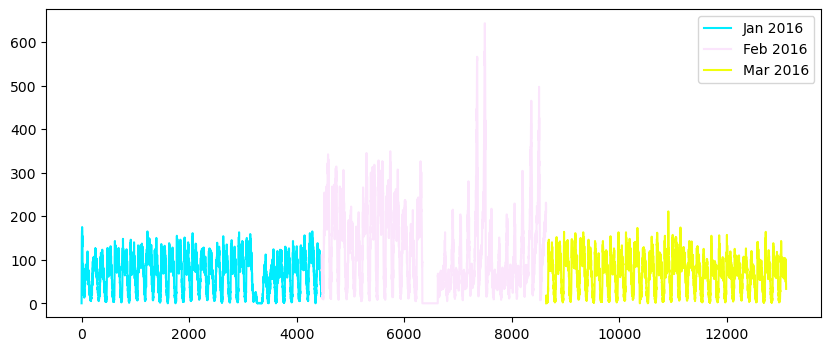

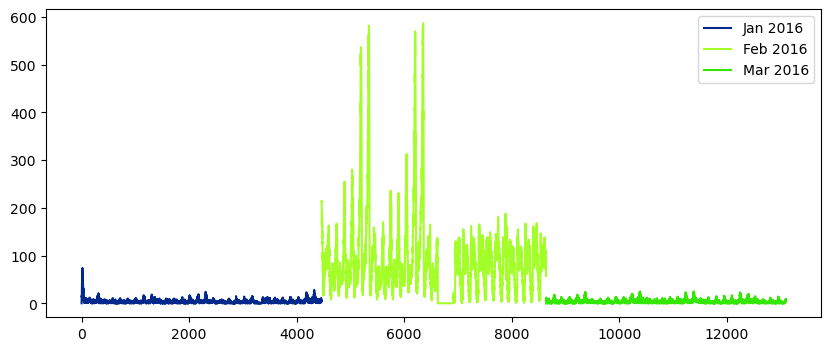

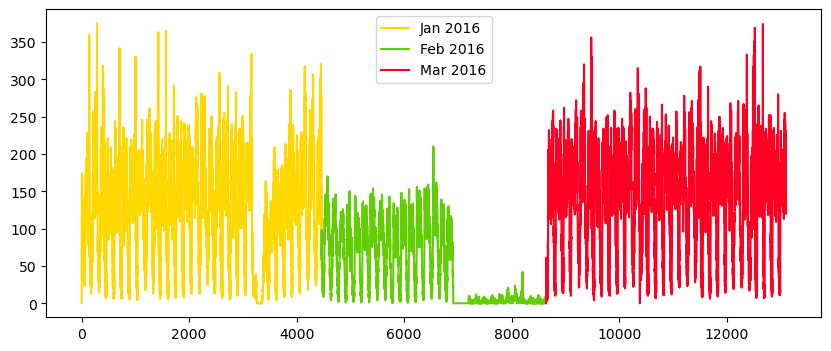

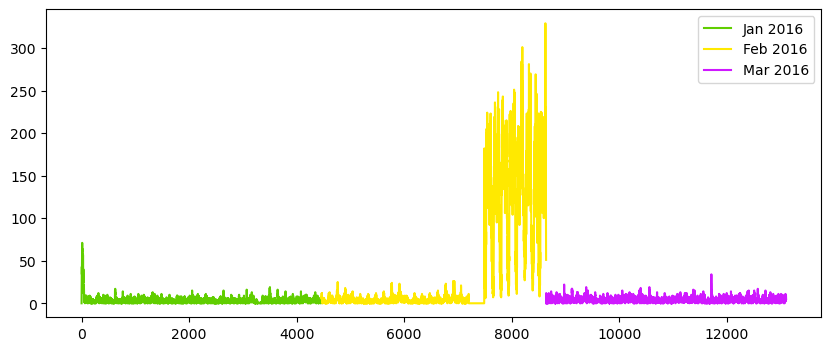

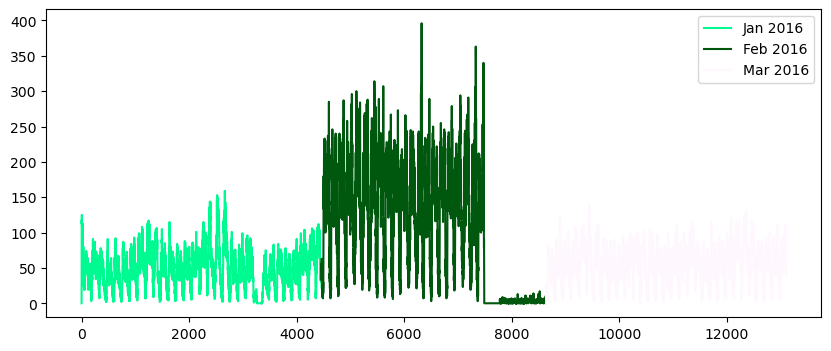

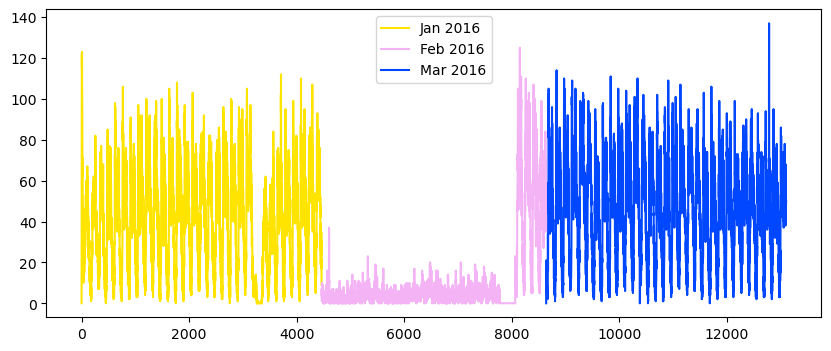

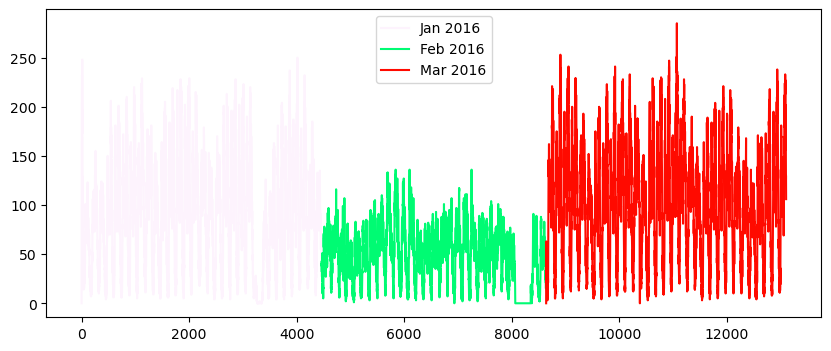

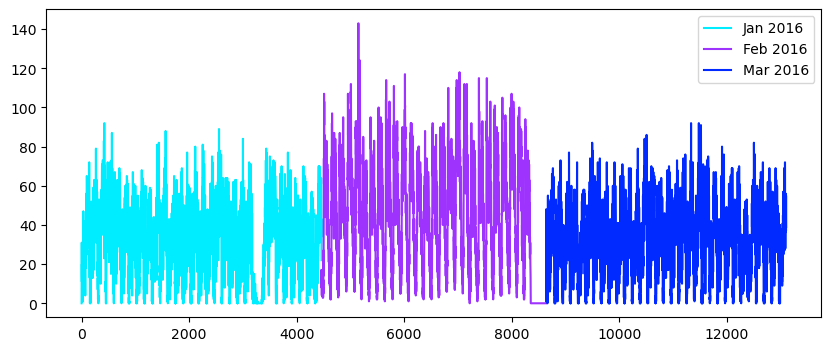

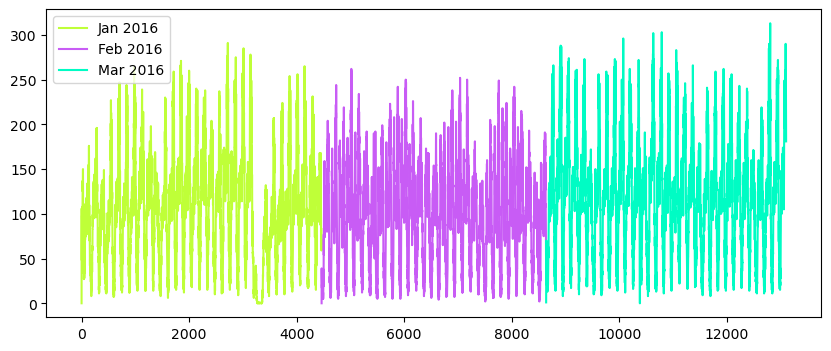

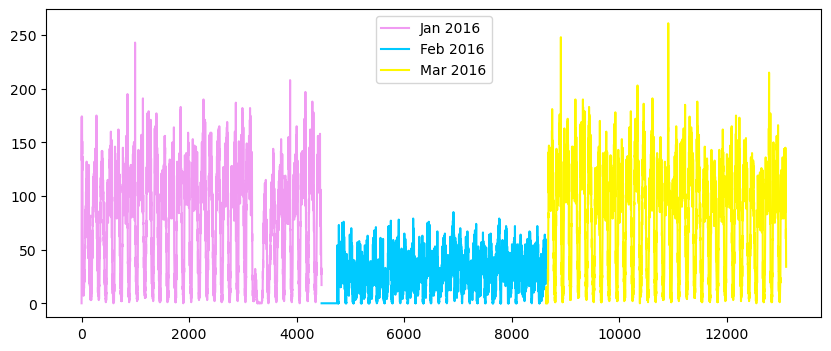

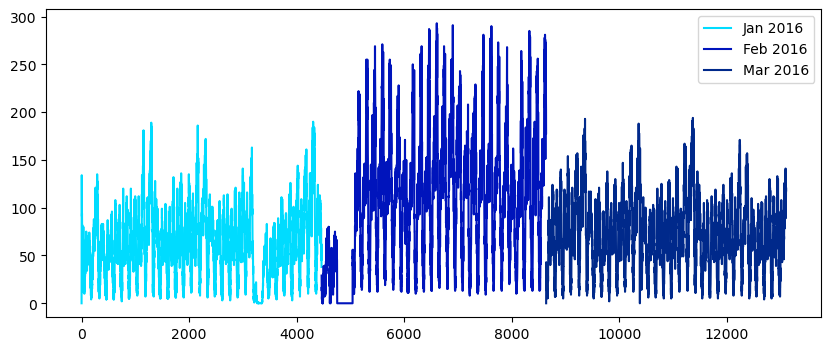

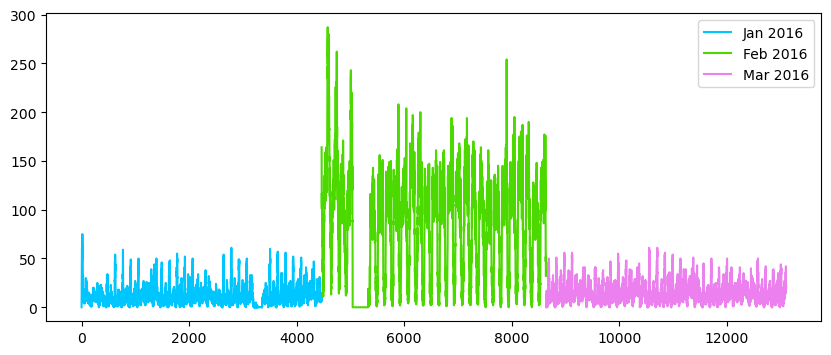

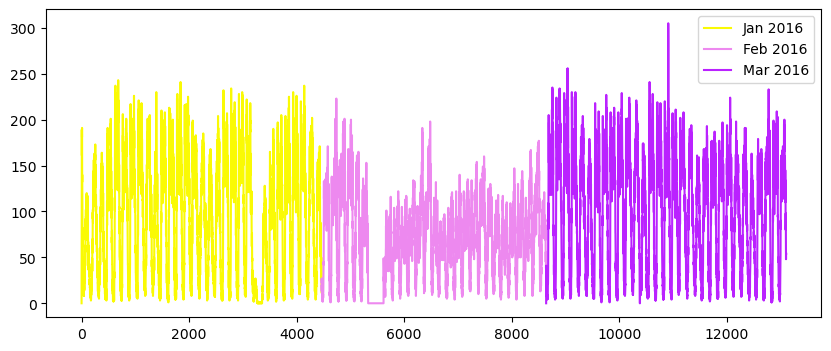

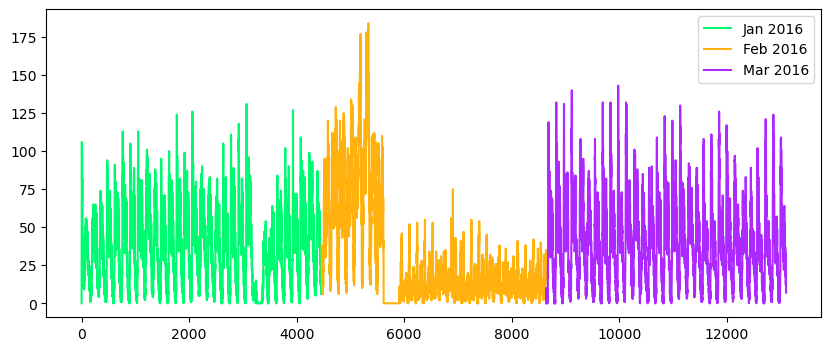

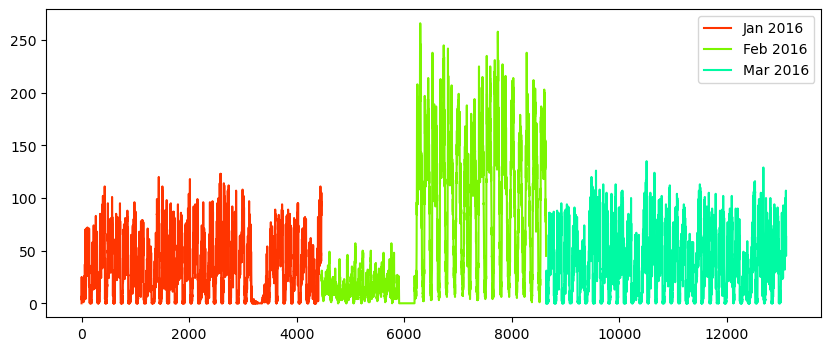

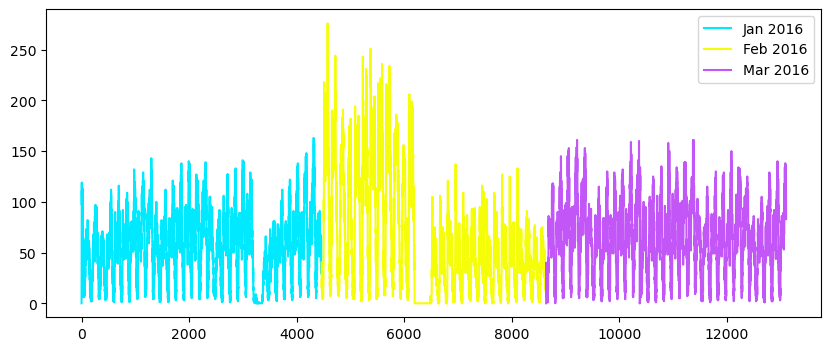

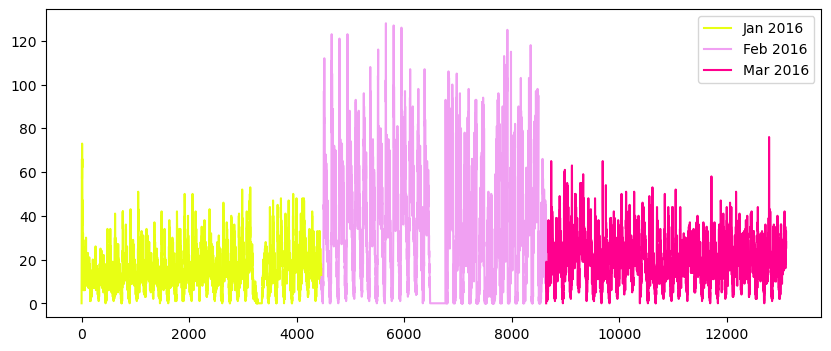

In [56]:
# A function to generate unique colors
def uniqueish_color():
    return plt.cm.gist_ncar(np.random.random())

first_x = list(range(0,4464))
second_x = list(range(4464,8640))
third_x = list(range(8640,13104))

for i in range(40):
    plt.figure(figsize = (10,4))
    plt.plot(first_x,regions_cum[i][:4464], color = uniqueish_color(), label='Jan 2016')
    plt.plot(second_x,regions_cum[i][4464:8640], color = uniqueish_color(), label='Feb 2016')
    plt.plot(third_x,regions_cum[i][8640:], color = uniqueish_color(), label='Mar 2016')
    plt.legend()
    plt.show()

# 3. Modelling: Baseline Models
Now we get into modelling, in order to forecast the pickup densities for the months of Jan, Feb and March of 2016 for which we are using multiple models with two variations 
1. Using Ratios of the 2016 data to the 2015 data i.e., $\begin{align} R_{t} = P^{2016}_{t} / P^{2015}_{t} \end{align}$
2. Using previous known values of the 2016 data itself to predict the future values

In [57]:
# Preparing the Dataframe only with x(i) values as Jan 2015 data and y(i) values as Jan 2016
ratios_jan = pd.DataFrame()
ratios_jan['Given'] = jan_2015_smooth
ratios_jan['Prediction'] = jan_2016_smooth
ratios_jan['Ratios'] = ratios_jan['Prediction']*1.0 / ratios_jan['Given']*1.0

## 3.1. Simple Moving Averages
- The first model used is the Moving Averages Model which uses the previous 'n' values in order to predict the next value
- Using Ratio Values - $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3} .... R_{t-n} )/n \end{align}$
- In the below code cells, the window-size (n) is a hyper-parameter, which is tuned manually.
- It is found that the window-size of 3 is optimal for getting the best results using Moving Averages with previous ratio values, therefore, we get $\begin{align}R_{t} = ( R_{t-1} + R_{t-2} + R_{t-3})/3 \end{align}$

In [58]:
def MA_R_Predictions(ratios):
    predicted_ratio = (ratios['Ratios'].values)[0]
    error, predicted_values, predicted_ratio_values = [], [], []
    window_size = 3
    for i in range(0, 4464*40):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_val = int(((ratios['Given'].values)[i])*predicted_ratio)
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(predicted_val)
        error.append( abs(predicted_val-(ratios['Prediction'].values)[i]) )
        if i+1 >= window_size:
            predicted_ratio = sum((ratios['Ratios'].values)[(i+1)-window_size:(i+1)]) / window_size
        else:
            predicted_ratio = sum((ratios['Ratios'].values)[0:(i+1)]) / (i+1)
            
    ratios['MA_R_Predicted'] = predicted_values
    ratios['MA_R_Error'] = error
    
    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error]) / len(error)
    return ratios, mape_err, mse_err

- Next, we use the Moving averages of the 2016 values themselves, to predict the future value using $\begin{align}P_{t} = ( P_{t-1} + P_{t-2} + P_{t-3} .... P_{t-n} )/n \end{align}$
- Once again, the window-size (n) is a hyper-parameter, which is tuned manually.
- And it is found that the window-size of 1 is optimal for getting the best results using Moving Averages with previous 2016 values, therefore we get $\begin{align}P_{t} = P_{t-1} \end{align}$

In [59]:
def MA_P_Predictions(ratios):
    predicted_value = (ratios['Prediction'].values)[0]
    error, predicted_values = [], []
    window_size = 1
    for i in range(0, 4464*40):
        predicted_values.append(predicted_value)
        error.append(abs(predicted_value-(ratios['Prediction'].values)[i]))
        if i+1 >= window_size:
            predicted_value = int(sum((ratios['Prediction'].values)[(i+1)-window_size:(i+1)]) / window_size)
        else:
            predicted_value = int(sum((ratios['Prediction'].values)[0:(i+1)]) / (i+1))
            
    ratios['MA_P_Predicted'] = predicted_values
    ratios['MA_P_Error'] = error
    
    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error]) / len(error)
    return ratios, mape_err, mse_err

## 3.2. Weighted Moving Averages
- The Moving Avergaes Model used above gave equal importance to all the values in the window used, but we know intuitively that the future is more likely to be similar to the latest values and less similar to the older values. 
- Weighted Averages converts this analogy into a mathematical relationship giving the highest weight while computing the averages to the latest previous value and decreasing weights to the subsequent older ones.
- Weighted Moving Averages using Ratio Values: $\begin{align}R_{t} = ( N*R_{t-1} + (N-1)*R_{t-2} + (N-2)*R_{t-3} .... 1*R_{t-n} )/(N*(N+1)/2) \end{align}$
- In the below code cells, the window-size (n) is a hyper-parameter, which is tuned manually.
- It is found that the window-size of 5 is optimal for getting the best results using Weighted Moving Averages with previous Ratio values, therefore, we get $\begin{align} R_{t} = ( 5*R_{t-1} + 4*R_{t-2} + 3*R_{t-3} + 2*R_{t-4} + R_{t-5} )/15 \end{align}$

In [60]:
def WA_R_Predictions(ratios):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha, window_size = 0.5, 5
    error, predicted_values, predicted_ratio_values = [], [], []
    for i in range(0, 4464*40):
        if i%4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_val = int(((ratios['Given'].values)[i])*predicted_ratio)
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(predicted_val)
        error.append( abs(predicted_val-(ratios['Prediction'].values)[i]) )
    
        sum_values = 0
        sum_of_coeff = 0
        if i+1 >= window_size:
            for j in range(window_size, 0, -1):
                sum_values += j*(ratios['Ratios'].values)[i-window_size+j]
                sum_of_coeff += j
        else:
            for j in range(i+1, 0, -1):
                sum_values += j*(ratios['Ratios'].values)[j-1]
                sum_of_coeff += j
                
        predicted_ratio = sum_values / sum_of_coeff
            
    ratios['WA_R_Predicted'] = predicted_values
    ratios['WA_R_Error'] = error
    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios, mape_err, mse_err

- Weighted Moving Averages using Previous 2016 Values: $\begin{align}P_{t} = ( N*P_{t-1} + (N-1)*P_{t-2} + (N-2)*P_{t-3} .... 1*P_{t-n} )/(N*(N+1)/2) \end{align}$
- Once again, the window-size (n) is a hyper-parameter, which is tuned manually.
- And it is found that the window-size of 2 is optimal for getting the best results using Weighted Moving Averages with previous 2016 values, therefore, we get $\begin{align} P_{t} = ( 2*P_{t-1} + P_{t-2} )/3 \end{align}$

In [61]:
def WA_P_Predictions(ratios):
    predicted_value=(ratios['Prediction'].values)[0]
    error, predicted_values = [], []
    window_size = 2
    for i in range(0, 4464*40):
        predicted_values.append(predicted_value)
        error.append(abs(predicted_value-(ratios['Prediction'].values)[i]))
        
        sum_values = 0
        sum_of_coeff = 0
        if i+1 >= window_size:
            for j in range(window_size, 0, -1):
                sum_values += j*(ratios['Prediction'].values)[i-window_size+j]
                sum_of_coeff += j

        else:
            for j in range(i+1,0,-1):
                sum_values += j*(ratios['Prediction'].values)[j-1]
                sum_of_coeff+=j
        
        predicted_value = int(sum_values / sum_of_coeff)
    
    ratios['WA_P_Predicted'] = predicted_values
    ratios['WA_P_Error'] = error
    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios, mape_err, mse_err

## 3.3. Exponential  Weighted Moving Averages
- Reference: https://en.wikipedia.org/wiki/Moving_average#Exponential_moving_average
- Through weighted averaged we have satisfied the analogy of giving higher weights to the latest value and decreasing weights to the subsequent ones, but we still do not know which is the correct weighting scheme as there are infinitely many possibilities in which we can assign weights in a non-increasing order and tune the hyperparameter window-size. 
- To simplify this process, we use **Exponential Moving Averages** which is a more logical way towards assigning weights and at the same time, also using an optimal window-size.
- In exponential moving averages, we use a single hyperparameter alpha $\begin{align}(\alpha)\end{align}$ which is a value between 0 & 1 and based on the value of the hyperparameter alpha the weights and the window sizes are configured.
- For eg. If $\begin{align}\alpha=0.9\end{align}$ then the number of days on which the value of the current iteration is based is ~ $\begin{align}1/(1-\alpha)=10\end{align}$ i.e. we consider values 10 days prior before we predict the value for the current iteration. 
- Also, the weights are assigned using $\begin{align}2/(N+1)=0.18\end{align}$, where N = number of prior values being considered, hence from this it is implied that the first or latest value is assigned a weight of 0.18 which keeps exponentially decreasing for the subsequent values.


$\begin{align}R^{'}_{t} = \alpha*R_{t-1} + (1-\alpha)*R^{'}_{t-1}  \end{align}$

In [62]:
def EA_R1_Predictions(ratios):
    predicted_ratio=(ratios['Ratios'].values)[0]
    alpha = 0.6
    error, predicted_values, predicted_ratio_values = [], [], []
    for i in range(0, 4464*40):
        if i % 4464 == 0:
            predicted_ratio_values.append(0)
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_val = int(((ratios['Given'].values)[i])*predicted_ratio)
        predicted_ratio_values.append(predicted_ratio)
        predicted_values.append(predicted_val)
        error.append(abs((predicted_val - (ratios['Prediction'].values)[i])))
        predicted_ratio = (alpha*predicted_ratio) + (1-alpha)*((ratios['Ratios'].values)[i])
    
    ratios['EA_R1_Predicted'] = predicted_values
    ratios['EA_R1_Error'] = error
    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios, mape_err, mse_err

- Exponential Weighted Moving Averages using Previous 2016 Values:
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$

In [63]:
def EA_P1_Predictions(ratios):
    predicted_value= (ratios['Prediction'].values)[0]
    alpha = 0.3
    error, predicted_values = [], []
    for i in range(0, 4464*40):
        if i % 4464 == 0:
            predicted_values.append(0)
            error.append(0)
            continue
        predicted_values.append(predicted_value)
        error.append(abs((predicted_value-(ratios['Prediction'].values)[i])))
        predicted_value =int((alpha*predicted_value) + (1-alpha)*((ratios['Prediction'].values)[i]))
    
    ratios['EA_P1_Predicted'] = predicted_values
    ratios['EA_P1_Error'] = error
    avg_pred_val = (sum(ratios['Prediction'].values) / len(ratios['Prediction'].values))
    mape_err = (1 / len(error)) * (sum(error) / avg_pred_val)
    mse_err = sum([e**2 for e in error])/len(error)
    return ratios, mape_err, mse_err

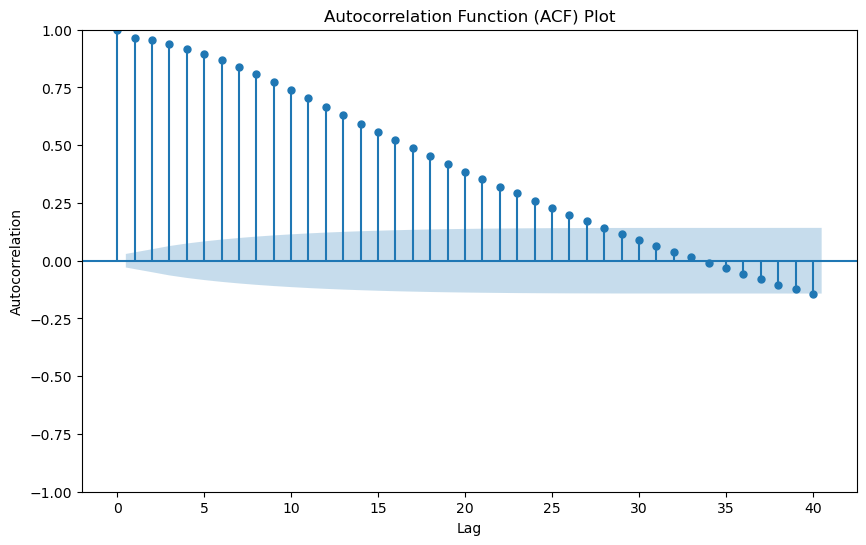

In [64]:
# Generate sample data
data=jan_2015_smooth[0:4464]

# Create a pandas Series
series = pd.Series(data)

# Plot ACF
plt.figure(figsize=(10, 6))
plot_acf(series, lags=40, ax=plt.gca())
plt.title('Autocorrelation Function (ACF) Plot')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.show()


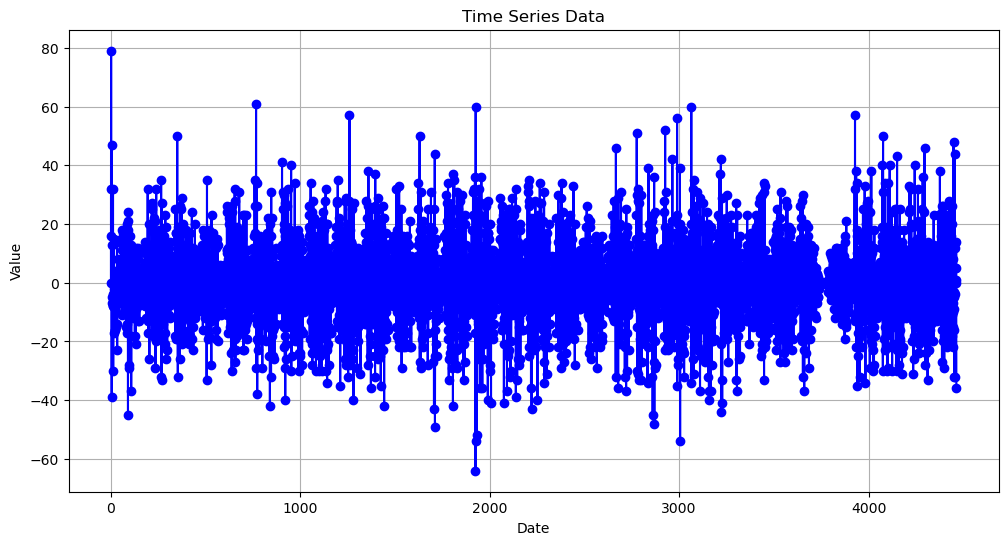

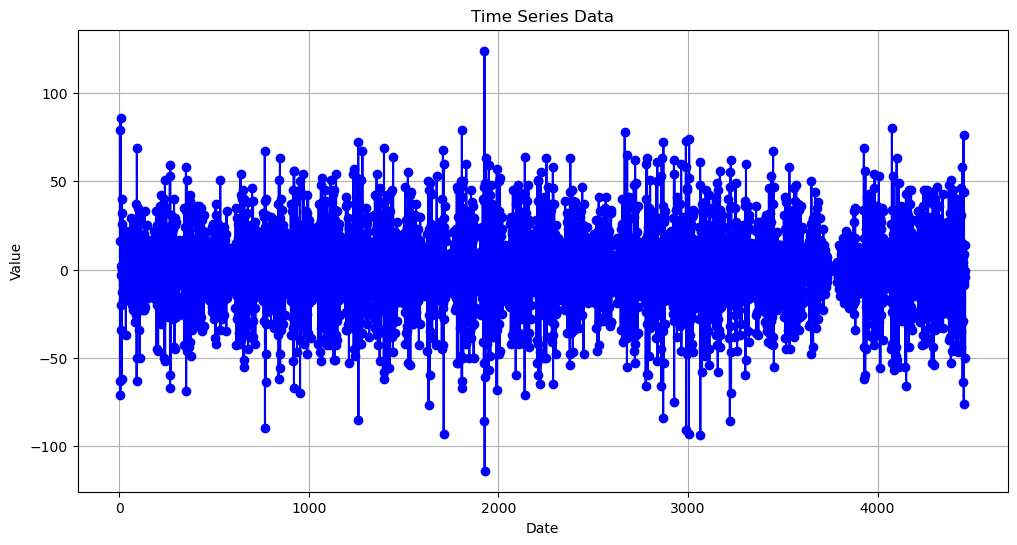

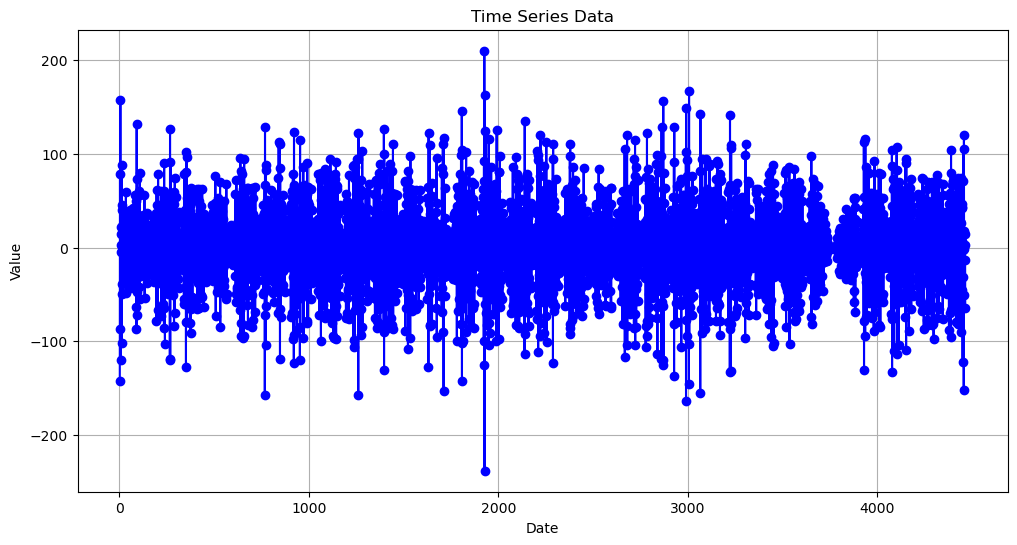

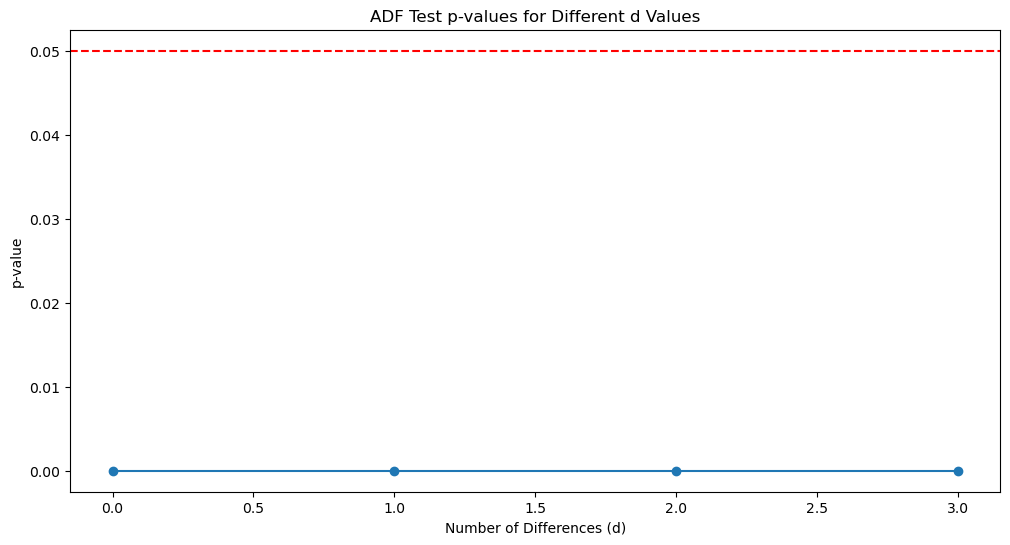

d=0: p-value=0.0000
d=1: p-value=0.0000
d=2: p-value=0.0000
d=3: p-value=0.0000


In [65]:
def adf_test(series):
    """
    Perform Augmented Dickey-Fuller test for stationarity.
    """
    result = adfuller(series.dropna(), autolag='AIC')
    return result[1]  # p-value of the test

def plot_stationarity_tests(p_values):
    """
    Plot ADF test p-values to determine the appropriate d.
    """
    plt.figure(figsize=(12, 6))
    plt.plot(range(len(p_values)), p_values, marker='o', linestyle='-')
    plt.axhline(y=0.05, color='r', linestyle='--')
    plt.xlabel('Number of Differences (d)')
    plt.ylabel('p-value')
    plt.title('ADF Test p-values for Different d Values')
    plt.show()

series = pd.Series(data)

# Perform ADF test for different d values
max_d = 3
p_values = []
for d in range(max_d + 1):
    p_value = adf_test(series)
    p_values.append(p_value)
    # Apply differencing if not at the last iteration
    if d < max_d:
        series = series.diff().dropna()
        dates = pd.date_range(start='2015-01-01', periods=100, freq='D')
        # Plotting the time series data
        plt.figure(figsize=(12, 6))
        plt.plot(series, marker='o', linestyle='-', color='b')  # Plot with markers and a line
        plt.title('Time Series Data')
        plt.xlabel('Date')
        plt.ylabel('Value')
        plt.grid(True)  # Add grid for better readability
        plt.show()

# Plot results
plot_stationarity_tests(p_values)

# Print out the results for inspection
for d, p_value in enumerate(p_values):
    print(f'd={d}: p-value={p_value:.4f}')


In [ ]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import ParameterGrid
import matplotlib.pyplot as plt

# Load and prepare data
y = data  # Assuming 'data' is a pandas Series with a datetime index

# Split data into train and test sets
train_size = int(len(y) * 0.8)
train, test = y[:train_size], y[train_size:]

# Define ARIMA model function
def arima_model(y, order):
    model = ARIMA(y, order=order)
    results = model.fit(disp=False)
    return results

# Define hyperparameter grid
param_grid = {
    'p': [28],  # AR terms
    'd': [0],  # Differencing terms
    'q': [1, 2, 3]   # MA terms
}

# Define Grid Search
class ARIMAGridSearch:
    def __init__(self, param_grid):
        self.param_grid = param_grid
        self.best_params = None
        self.best_score = np.inf
        self.best_model = None

    def fit(self, y, test):
        for params in ParameterGrid(self.param_grid):
            try:
                order = (params['p'], params['d'], params['q'])
                model = arima_model(y, order)
                predictions = model.predict(start=test.index[0], end=test.index[-1])
                
                mse = np.mean((test - predictions) ** 2)
                
                if mse < self.best_score:
                    self.best_score = mse
                    self.best_params = params
                    self.best_model = model
            except Exception as e:
                print(f"Error with parameters {params}: {e}")

    def get_best_params(self):
        return self.best_params

    def get_best_model(self):
        return self.best_model

# Perform grid search
grid_search = ARIMAGridSearch(param_grid)
grid_search.fit(train, test)

# Output best parameters and fit the best model
best_params = grid_search.get_best_params()
best_model = grid_search.get_best_model()
print(f"Best parameters: {best_params}")

# Generate predictions with the best model
predictions = best_model.predict(start=test.index[0], end=test.index[-1])

# Define MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    nonzero_mask = y_true != 0
    return np.mean(np.abs((y_true[nonzero_mask] - y_pred[nonzero_mask]) / y_true[nonzero_mask])) * 100

# Calculate MAPE
mape = mean_absolute_percentage_error(test, predictions)
print(f'MAPE: {mape:.2f}%')

# Plot results
plt.figure(figsize=(12, 8))
plt.plot(train.index, train, label='Training Data')
plt.plot(test.index, test, label='Test Data')
plt.plot(test.index, predictions, label='Predicted', color='red')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Value')
plt.show()

In [67]:
mape_err = [0]*10
mse_err = [0]*10
ratios_jan, mape_err[0], mse_err[0] = MA_R_Predictions(ratios_jan)
ratios_jan, mape_err[1], mse_err[1] = MA_P_Predictions(ratios_jan)
ratios_jan, mape_err[2], mse_err[2] = WA_R_Predictions(ratios_jan)
ratios_jan, mape_err[3], mse_err[3] = WA_P_Predictions(ratios_jan)
ratios_jan, mape_err[4], mse_err[4] = EA_R1_Predictions(ratios_jan)
ratios_jan, mape_err[5], mse_err[5] = EA_P1_Predictions(ratios_jan)

## 3.4. Comparison between Baseline Models
- We have chosen our error metric for comparison between models as <b>MAPE (Mean Absolute Percentage Error)</b>, so that we can know, on an average how good is our model with predictions
- <b>MSE (Mean Squared Error)</b> is also used, so that we have a clearer understanding as to how well our forecasting model performs with outliers, & it helps us to make sure that there is not much of an error margin between our predicted and the actual value.

In [68]:
x = PrettyTable()

x.field_names = ["Baseline Model", "MAPE", "MSE"]
x.add_rows([
    ["Simple Moving Averages (Ratios)", mape_err[0], mse_err[0]],
    ["Simple Moving Averages (2016 Values)", mape_err[1], mse_err[1]],
    ["Weighted Moving Averages (Ratios)", mape_err[2], mse_err[2]],
    ["Weighted Moving Averages (2016 Values)", mape_err[3], mse_err[3]],
    ["Exponential Weighted Moving Averages (Ratios)", mape_err[4], mse_err[4]],
    ["Exponential Weighted Moving Averages (2016 Values)", mape_err[5], mse_err[5]]
])

print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print(x)

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
+----------------------------------------------------+---------------------+--------------------+
|                   Baseline Model                   |         MAPE        |        MSE         |
+----------------------------------------------------+---------------------+--------------------+
|          Simple Moving Averages (Ratios)           | 0.19178186522216736 | 421.45580197132614 |
|        Simple Moving Averages (2016 Values)        | 0.14675899140679008 | 175.0428483422939  |
|         Weighted Moving Averages (Ratios)          | 0.18788991386053108 |  399.566061827957  |
|       Weighted Moving Averages (2016 Values)       | 0.13908810514470915 | 161.93304211469535 |
|   Exponential Weighted Moving Averages (Ratios)    | 0.18675060613207145 | 386.5556843637993  |
| Exponential Weighted Moving Averages (2016 Values) | 0.13864452260395205 | 159.37525761648746 |
+----------------------------------------------------+---------

- **Note**: The above comparisons are made using Jan 2015 and Jan 2016 data only
- From the above results, we can infer that the best forecasting model for our predictions would be:
$\begin{align}P^{'}_{t} = \alpha*P_{t-1} + (1-\alpha)*P^{'}_{t-1}  \end{align}$ i.e **Exponential Weighted Moving Averages using 2016 Values**.

# 4. Regression Models
## 4.1. Preparing Data & Performing Train-Test Split
- Before we start predictions using the tree-based & other regression models, we take 3 months of 2016 pickup data and split it such that, for every region we have 70% data in train and 30% in test, ordered date-wise for every region.
- The below code cells prepares data in cumulative form which will be later split into test and train sets.

### 4.1.1. Preparing Data

In [69]:
# Number of 10-min indices for Jan 2016: 24*31*60/10 = 4464
# Number of 10-min indices for Feb 2016: 24*29*60/10 = 4176
# Number of 10-min indices for Mar 2016: 24*31*60/10 = 4464
# regions_cum: It will contain 40 lists, each list will contain (4464+4176+4464) = 13104 values 
# which represents the #pickups that have happened for three months in 2016.

# Since, we are considering the #pickups for the last 5 time-bins, hence, we are omitting the 
# first 5 time bins from our dataframe, and therefore, our prediction starts from 5th 10-min interval


# We take #pickups that have happened in last 5 10-min intervals
number_of_time_stamps = 5

# It is a list of lists
# It will contain 13099 #pickups for each cluster
output = []

# tsne_lat will contain 13099 times latitude of cluster center for every cluster
# Ex: [[cent_lat 13099times], [cent_lat 13099times], [cent_lat 13099times] .... 40 lists]
# It is a list of lists
tsne_lat = []


# tsne_lon will contain 13099 times longitude of cluster center for every cluster
# Ex: [[cent_long 13099times], [cent_long 13099times], [cent_long 13099times] .... 40 lists]
# It is a list of lists
tsne_lon = []

# We will code each day as below
# Sun = 0, Mon = 1, Tue = 2, Wed = 3, Thu = 4, Fri = 5, Sat = 6
# For every cluster, we will be adding 13099 values, each value represent to which day of 
# the week that pickup bin belongs to.
# It is a list of lists
tsne_weekday = []

# It's a numpy array of shape (40 * 13099, 5) = (523960, 5)
# Each row corresponds to an entry in out data
# For the first row we will have [f0,f1,f2,f3,f4], where fi = #pickups happened in (i+1)th 
# 10-min interval (bin). The second row will have [f1,f2,f3,f4,f5]
# The third row will have [f2,f3,f4,f5,f6], and so on...
tsne_feature = []
tsne_feature = [0] * number_of_time_stamps

# Jan 2016 is Thursday, so we start our day from 4: "(int(k/144))%7+4"
# regions_cum is a list of lists 
# [[x1,x2,x3..x13104], [x1,x2,x3..x13104], [x1,x2,x3..x13104], ... 40 lists]

for i in range(0, 40):
    tsne_lat.append([kmeans.cluster_centers_[i][0]]*13099)
    tsne_lon.append([kmeans.cluster_centers_[i][1]]*13099)
    tsne_weekday.append([int(((int(k/144))%7+4)%7) for k in range(5,4464+4176+4464)])
    tsne_feature = np.vstack((tsne_feature, [
        regions_cum[i][r : r + number_of_time_stamps] \
        for r in range(0, len(regions_cum[i]) - number_of_time_stamps)
    ]))
    output.append(regions_cum[i][5:])

# Removing the first dummy row
tsne_feature = tsne_feature[1:]

print(len(tsne_lat[0])*len(tsne_lat))
print(tsne_feature.shape[0])
print(len(tsne_weekday)*len(tsne_weekday[0]))
print(len(output)*len(output[0]))

523960
523960
523960
523960


In [70]:
# Adding the FFT-Based Features, Removing the first 5 rows for each of the clusters
# fft_feat_rem5 = fft_feat[ : ,5: , :]
# print(fft_feat_rem5.shape)

# fft_feat_prep = fft_feat_rem5.reshape((523960, 4))
# print(fft_feat_prep.shape)

# tsne_feature = np.hstack([tsne_feature, fft_feat_prep])
# print(tsne_feature.shape)

- Getting the predictions of EWMA to be used as a feature in cumulative form.
- Upto now we computed 8 features for every data-point that starts from 50th-min of the day
    1. Cluster center lattitude
    2. Cluster center longitude
    3. Day of the week 
    4. f_t_1: #pickups that have happened in the previous (t-1)th 10-min interval
    5. f_t_2: #pickups that have happened in the previous (t-2)th 10-min interval
    6. f_t_3: #pickups that have happened in the previous (t-3)th 10-min interval
    7. f_t_4: #pickups that have happened in the previous (t-4)th 10-min interval
    8. f_t_5: #pickups that have happened in the previous (t-5)th 10-min interval

In [71]:
# From the baseline models we said that the EWMA gives us the least error
# We will try to add the same EWMA at t as a feature to our data
# EWMA => P'(t) = alpha * P'(t-1) + (1-alpha) * P(t-1) 
alpha = 0.3

# It is a temporary array that stores EWMA for each 10-min interval, 
# For each cluster it will get reset. For every cluster it contains 13104 values
predicted_values = []

# It is similar like tsne_lat
# It is a list of lists
# [[x5,x6,x7..x13104], [x5,x6,x7..x13104], [x5,x6,x7..x13104], .. 40 lists]
predict_list = []
tsne_flat_exp_avg = []

for r in range(0,40):
    for i in range(0,13104):
        if i==0:
            predicted_value = regions_cum[r][0]
            predicted_values.append(0)
            continue
        predicted_values.append(predicted_value)
        predicted_value = int((alpha*predicted_value) + (1-alpha)*(regions_cum[r][i]))
    predict_list.append(predicted_values[5:])
    predicted_values = []

### 4.1.2. Performing train-test split

In [72]:
# train-test split: 70%-30% split
print("Size of train data:", int(13099*0.7))
print("Size of test data:", int(13099*0.3))

Size of train data: 9169
Size of test data: 3929


In [73]:
# Extracting first 9169 timestamp values i.e., 70% of 13099 (total timestamps) for our training data
train_features =  [tsne_feature[13099*i:(13099*i+9169)] for i in range(0,40)]
# temp = [0]*(12955 - 9068)
test_features = [tsne_feature[13099*i+9169:13099*(i+1)] for i in range(0,40)]

In [74]:
print("Number of Data-clusters:", len(train_features), "\nNumber of data points in train data", 
    len(train_features[0]), "\nEach data-point contains", len(train_features[0][0]),"features")
print("\n")
print("Number of Data-clusters:", len(test_features), "\nNumber of data points in test data", 
    len(test_features[0]), "\nEach data-point contains", len(test_features[0][0]), "features")

Number of Data-clusters: 40 
Number of data points in train data 9169 
Each data-point contains 5 features


Number of Data-clusters: 40 
Number of data points in test data 3930 
Each data-point contains 5 features


In [75]:
# Extracting first 9169 timestamp values i.e., 70% of 13099 (total timestamps) for our training data
tsne_train_flat_lat = [i[:9169] for i in tsne_lat]
tsne_train_flat_lon = [i[:9169] for i in tsne_lon]
tsne_train_flat_weekday = [i[:9169] for i in tsne_weekday]
tsne_train_flat_output = [i[:9169] for i in output]
tsne_train_flat_exp_avg = [i[:9169] for i in predict_list]

In [76]:
# Extracting the rest of the timestamp values i.e., 30% of 13099 (total timestamps) for our test data
tsne_test_flat_lat = [i[9169:] for i in tsne_lat]
tsne_test_flat_lon = [i[9169:] for i in tsne_lon]
tsne_test_flat_weekday = [i[9169:] for i in tsne_weekday]
tsne_test_flat_output = [i[9169:] for i in output]
tsne_test_flat_exp_avg = [i[9169:] for i in predict_list]

In [77]:
# The above variables contain values in the form of list of lists (i.e., list of values of 
# each region), here we make all of them in one list.
train_new_features = []
for i in range(0, 40):
    train_new_features.extend(train_features[i])
    
test_new_features = []
for i in range(0, 40):
    test_new_features.extend(test_features[i])

In [78]:
# Converting lists of lists into a single list i.e., flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_train_lat = sum(tsne_train_flat_lat, [])
tsne_train_lon = sum(tsne_train_flat_lon, [])
tsne_train_weekday = sum(tsne_train_flat_weekday, [])
tsne_train_output = sum(tsne_train_flat_output, [])
tsne_train_exp_avg = sum(tsne_train_flat_exp_avg,[])

In [79]:
# Converting lists of lists into a single list i.e., flatten
# a  = [[1,2,3,4],[4,6,7,8]]
# print(sum(a,[]))
# [1, 2, 3, 4, 4, 6, 7, 8]

tsne_test_lat = sum(tsne_test_flat_lat, [])
tsne_test_lon = sum(tsne_test_flat_lon, [])
tsne_test_weekday = sum(tsne_test_flat_weekday, [])
tsne_test_output = sum(tsne_test_flat_output, [])
tsne_test_exp_avg = sum(tsne_test_flat_exp_avg,[])

In [80]:
# Preparing the data-frame for our train data

# Considering FFT-Based Features
# columns = ['ft_5','ft_4','ft_3','ft_2','ft_1', 'len_peaks', 'freq_1', 'freq_2', 'freq_3']
# Not Considering FFT-Based Features
columns = ['ft_5','ft_4','ft_3','ft_2','ft_1']

df_train = pd.DataFrame(data = train_new_features, columns = columns) 
df_train['lat'] = tsne_train_lat
df_train['lon'] = tsne_train_lon
df_train['weekday'] = tsne_train_weekday
df_train['exp_avg'] = tsne_train_exp_avg
print(df_train.shape)

(366760, 9)


In [81]:
df_train.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg
0     0    46    98    88   120  40.709712 -74.011243        4      109
1    46    98    88   120   137  40.709712 -74.011243        4      128
2    98    88   120   137   153  40.709712 -74.011243        4      145
3    88   120   137   153   168  40.709712 -74.011243        4      161
4   120   137   153   168   144  40.709712 -74.011243        4      149

In [82]:
# Preparing the data-frame for our test data
df_test = pd.DataFrame(data=test_new_features, columns=columns) 
df_test['lat'] = tsne_test_lat
df_test['lon'] = tsne_test_lon
df_test['weekday'] = tsne_test_weekday
df_test['exp_avg'] = tsne_test_exp_avg
print(df_test.shape)

(157200, 9)


In [83]:
df_test.head()

ft_5  ft_4  ft_3  ft_2  ft_1        lat        lon  weekday  exp_avg
0   111    91    85    90    94  40.709712 -74.011243        4       92
1    91    85    90    94   100  40.709712 -74.011243        4       97
2    85    90    94   100   127  40.709712 -74.011243        4      117
3    90    94   100   127   108  40.709712 -74.011243        4      110
4    94   100   127   108   124  40.709712 -74.011243        4      119

#### Observations:
- In the above code cells, we can see how we have incorporrated the information conveyed by the geographical location and the time-bin, into 9 features of our dataset.
- So, now, if we are given a test-point, we will first consider the coordinates, which we will pass to our MiniBatchKMeans model, which will predict the cluster for these coordinates.
- Using the predicted cluster, we will find out the coordinates of the predicted cluster's center, since, we have the coordinates of each of the cluster's center (pre-computed, while training).
- The cluster's center's latitude and longitude will form up 2 of our 9 features.
- Now, since, we have the time-bin, we can easily calculate the weekday. Also, since, we would have the pickup density of the last 5 time-bins for the given cluster, another 5 features will be obtained.
- And in a similar fashion, we would have the `exp_avg`, which will be computed based-off the pickup density of the previous time-bins.
- In this way, using just the time-bins and the geographical location of the cabbie, we can find out the 9 features, using which, we can predict the pickup density for the given region and time-bin.

## 4.2. Modelling using Regression Models
### 4.2.1. Linear Regression Model

In [84]:
# No hyper-parameter tuning to do
lr_reg = LinearRegression().fit(df_train, tsne_train_output)
y_pred = lr_reg.predict(df_train)
lr_train_predictions = [round(value) for value in y_pred]
y_pred = lr_reg.predict(df_test)
lr_test_predictions = [round(value) for value in y_pred]

### 4.2.2. Random Forest Regressor Model

In [85]:
# params = {
#     'max_features': ['auto', 'sqrt', 'log2'],
#     'min_samples_leaf': [1, 2, 3, 4],
#     'min_samples_split': [1, 2, 3, 4],
#     'n_estimators': [i for i in range(0, 101, 20)],
#     'n_jobs': [-1]
# }
# rfr = RandomForestRegressor()
# model = RandomizedSearchCV(rfr, params, verbose = 1)
# model.fit(df_train, tsne_train_output)
# print(model.best_params_)

# Best Params found using RandomizedSearch
# {'n_jobs': -1, 'n_estimators': 40, 'min_samples_split': 3, 
# 'min_samples_leaf': 4, 'max_features': 'sqrt'}

In [86]:
# Training the Model with the best hyper-parameters found using the above Randomized Search
regr1 = RandomForestRegressor(max_features='sqrt', min_samples_leaf = 4,
    min_samples_split = 3, n_estimators = 40, n_jobs = -1)
regr1.fit(df_train, tsne_train_output)

RandomForestRegressor(max_features='sqrt', min_samples_leaf=4,
                      min_samples_split=3, n_estimators=40, n_jobs=-1)

In [87]:
# Predicting on train & test data using our trained Random Forest model 
y_pred = regr1.predict(df_train)
rndf_train_predictions = [round(value) for value in y_pred]
y_pred = regr1.predict(df_test)
rndf_test_predictions = [round(value) for value in y_pred]

In [88]:
# Feature importances based on analysis using Random Forest
print (df_train.columns)
print (regr1.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[0.02404751 0.05282232 0.1539868  0.1094859  0.35575388 0.00234344
 0.00446983 0.00169471 0.29539561]


### 4.2.3. XgBoost Regressor Model

In [89]:
# params = {
#     'learning_rate': [0.01, 0.1, 1],
#     'n_estimators': [i for i in range(1, 1001, 250)],
#     'max_depth': [2, 3, 4],
#     'min_child_weight': [2, 3, 4],
#     'gamma': [0, 0.1, 0.5],
#     'subsample': [0.5, 0.8, 1],
#     'reg_alpha': [100, 200],
#     'reg_lambda': [100, 200],
#     'colsample_bytree': [0.4, 0.8, 1.0],
#     'n_jobs': [-1]
# }
# xgbr = xgb.XGBRegressor()
# model = RandomizedSearchCV(xgbr, params, verbose = 2)
# model.fit(df_train, tsne_train_output)
# print(model.best_params_)

# Best Params found using RandomizedSearch
# {'subsample': 0.8, 'reg_lambda': 200, 'reg_alpha': 200, 'n_jobs': -1, 
# 'n_estimators': 1000, 'min_child_weight': 3, 'max_depth': 3, 'learning_rate': 0.1, 
# 'gamma': 0, 'colsample_bytree': 0.8}

In [90]:
# Training the Model with the best hyper-parameters found using the above Randomized Search
x_model = xgb.XGBRegressor(
    learning_rate=0.1, n_estimators=1000, max_depth=3, min_child_weight=3,
    gamma=0, subsample=0.8, reg_alpha=200, reg_lambda=200, colsample_bytree=0.8, n_jobs=-1
)
x_model.fit(df_train, tsne_train_output)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=-1,
             num_parallel_tree=None, random_state=None, ...)

In [91]:
# Predicting on train & test data using our trained XgBoost regressor model
y_pred = x_model.predict(df_train)
xgb_train_predictions = [round(value) for value in y_pred]
y_pred = x_model.predict(df_test)
xgb_test_predictions = [round(value) for value in y_pred]

In [92]:
# Feature importances based on analysis using XgBoost
print (df_train.columns)
print(x_model.feature_importances_)

Index(['ft_5', 'ft_4', 'ft_3', 'ft_2', 'ft_1', 'lat', 'lon', 'weekday',
       'exp_avg'],
      dtype='object')
[1.3995335e-03 1.0164740e-03 2.6532384e-03 1.2909825e-01 1.5441059e-01
 9.5729908e-04 6.7895220e-04 1.7679032e-03 7.0801783e-01]


## 4.3. Calculating the Error Metric Values for the Various Models

In [93]:
train_mape = []
test_mape = []

train_mape.append((mean_absolute_error(tsne_train_output,df_train['ft_1'].values)) / (sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,df_train['exp_avg'].values)) / (sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output,rndf_train_predictions)) / (sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, xgb_train_predictions)) / (sum(tsne_train_output)/len(tsne_train_output)))
train_mape.append((mean_absolute_error(tsne_train_output, lr_train_predictions)) / (sum(tsne_train_output)/len(tsne_train_output)))

test_mape.append((mean_absolute_error(tsne_test_output, df_test['ft_1'].values)) / (sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, df_test['exp_avg'].values)) / (sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, rndf_test_predictions)) / (sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, xgb_test_predictions)) / (sum(tsne_test_output)/len(tsne_test_output)))
test_mape.append((mean_absolute_error(tsne_test_output, lr_test_predictions)) / (sum(tsne_test_output)/len(tsne_test_output)))

In [94]:
x = PrettyTable()

x.field_names = ["Model", "Train MAPE", "Test MAPE"]
x.add_rows([
    ["Baseline Model (2016 Values)", train_mape[0], test_mape[0]],
    ["Exponential Weighted Moving Averages (2016 Values)", train_mape[1], test_mape[1]],
    ["Random Forest Regressor", train_mape[2], test_mape[2]],
    ["XgBoost Regressor", train_mape[3], test_mape[3]],
    ["Linear Regression", train_mape[4], test_mape[4]]
])

print ("Error Metric Matrix (Forecasting Methods) - MAPE & MSE")
print(x)

Error Metric Matrix (Forecasting Methods) - MAPE & MSE
+----------------------------------------------------+---------------------+---------------------+
|                       Model                        |      Train MAPE     |      Test MAPE      |
+----------------------------------------------------+---------------------+---------------------+
|            Baseline Model (2016 Values)            | 0.14307797932494168 | 0.13985918750406173 |
| Exponential Weighted Moving Averages (2016 Values) |  0.135612282775639  |  0.1325762933456682 |
|              Random Forest Regressor               | 0.09384479090386073 | 0.13049908444162409 |
|                 XgBoost Regressor                  |  0.1335145917322456 | 0.13108301572313819 |
|                 Linear Regression                  | 0.13580179009149104 | 0.13224294599543557 |
+----------------------------------------------------+---------------------+---------------------+


In [95]:
print("Time taken to run this entire kernel is:", dt.now() - globalstart)

Time taken to run this entire kernel is: 0:44:32.703034
